# Fear Prediction with Audio and Visual Features and Low Level Cinematographic Features

The Mediaeval 2017 Emotional Impact of Movies Task includes the data in the emotional domain 
(valence - arousal  regression) and  fear ( binary classification).
We have displayed the valence and arousal of all the movies in the dataset.
Also the time of the movie where fear is present is specified with the value of the second.
According to the Russell's circumplex model we were expecting the "FEAR" to be appeared in the negative vallence, positive arousal part of the circumflex.
However in some movies, we can see that frightment exists in positive valence with negative arousal also.


In [1]:

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
import matplotlib.colors as colors


import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

import numpy as np
import pylab as pl
import re, fileinput
import os.path
import glob
import pickle
import sys


In [2]:
import numpy as np 
print(np.__version__) 
print(np.__path__)


1.11.3
['/home/yt/anaconda2/lib/python2.7/site-packages/numpy']


In [376]:
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import scipy
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [4]:
#Dev data
#movieNames = ['After_The_Rain','Attitude_Matters','Barely_legal_stories','Between_Viewings','Big_Buck_Bunny','Chatter','Cloudland','Damaged_Kung_Fu','Decay','Elephant_s_Dream','First_Bite','Full_Service','Islands','Lesson_Learned','Norm','Nuclear_Family','On_time','Origami','Parafundit','Payload','Riding_The_Rails','Sintel','Spaceman','Superhero','Tears_of_Steel','The_room_of_franz_kafka','The_secret_number','To_Claire_From_Sonny','Wanted','You_Again']

pathcontinuous = "/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/ContinuousLIRIS-ACCEDE/"
continuousAnnotationsFolder = pathcontinuous +'continuous-annotations/'
devdatacontinous =  pathcontinuous + "continuous-movies/"
pathcontfeatures = "/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/Continuous/features-out/"

datahome = '/home/yt/Desktop/mediaeval2017'

med2017visualFeaturesfolder='/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-DevSet-Visual_features/MEDIAEVAL17-DevSet-Visual_features/features/'
med2017audiofolder='/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-DevSet-Audio_features/MEDIAEVAL17-DevSet-Audio_features/features/'
med2017annotationsFolder = '/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-DevSet-Valence_Arousal-annotations/MEDIAEVAL17-DevSet-Valence_Arousal-annotations/annotations/'
med2017fearFolder = '/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-DevSet-Fear-annotations/MEDIAEVAL17-DevSet-Fear-annotations/annotations/'
med2017dataFolder = devdatacontinous

### Test Data
med2017visualfolderTest='/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-TestSet-Visual_features/MEDIAEVAL17-TestSet-Visual_features/visual_features/'
med2017audiofolderTest = '/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-TestSet-Audio_features/MEDIAEVAL17-TestSet-Audio_features/audio_features/'
med2017datafolderTest = '/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-TestSet-Data/MEDIAEVAL17-TestSet-Data/data/'

med2017testfeatures = "/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/Continuous/features-out/"

facesfolder = '/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/dlibfaces/'
framesfolder = '/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/movframes/'
openfacesfolder = '/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/faceinfo/'
faceslandmarksfolder = '/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/dlibfaceslandmarks/'

#frame-%05d.jpg

In [5]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

def displayframe(movie,number):
    filename = framesfolder+movie +'.mp4-'+ '{0:05d}'.format(number) +'.jpg'

    img=mpimg.imread(filename)
    plt.figure(figsize=(20,30))
    plt.grid(False)
    
    imgplot = plt.imshow(img)
    plt.show()


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


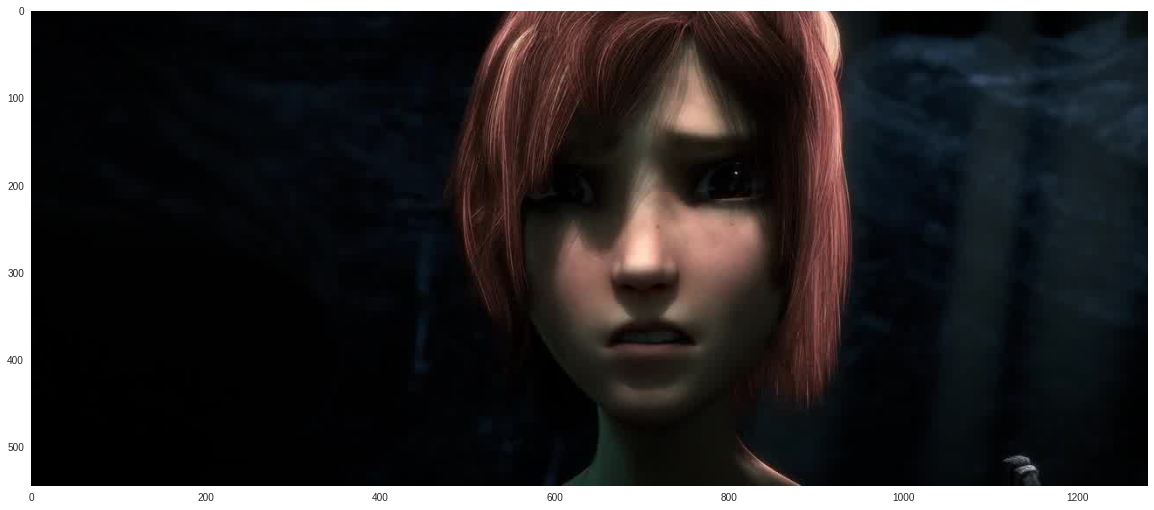

In [6]:
displayframe('Sintel',623)

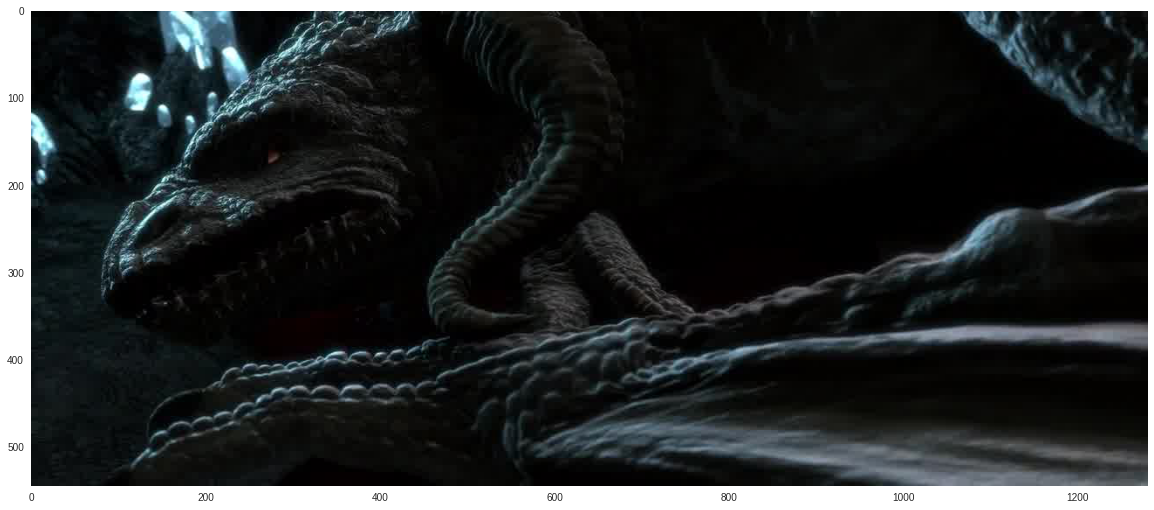

In [7]:
displayframe('Sintel',627)

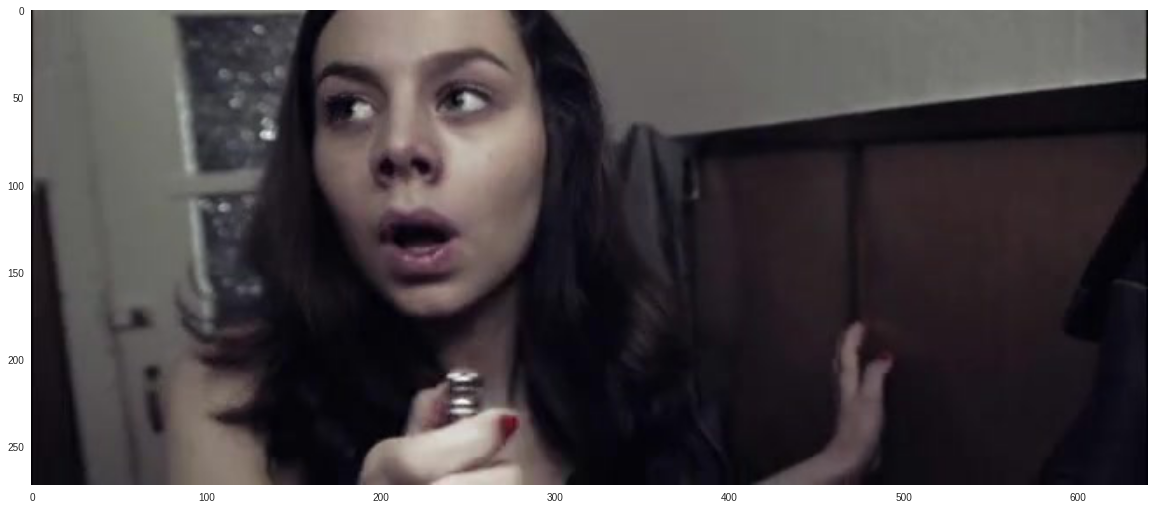

In [9]:
displayframe('Chatter',370)

In [10]:
files = glob.glob(med2017datafolderTest+'*')
testmovieNames =[ f.split('/')[-1].replace('.mp4','') for f in sorted(files) ]

In [11]:
files = glob.glob(med2017dataFolder+'*')
movieNames =[ f.split('/')[-1].replace('.mp4','') for f in sorted(files) ]

In [12]:
movieNames,testmovieNames

(['After_The_Rain',
  'Attitude_Matters',
  'Barely_legal_stories',
  'Between_Viewings',
  'Big_Buck_Bunny',
  'Chatter',
  'Cloudland',
  'Damaged_Kung_Fu',
  'Decay',
  'Elephant_s_Dream',
  'First_Bite',
  'Full_Service',
  'Islands',
  'Lesson_Learned',
  'Norm',
  'Nuclear_Family',
  'On_time',
  'Origami',
  'Parafundit',
  'Payload',
  'Riding_The_Rails',
  'Sintel',
  'Spaceman',
  'Superhero',
  'Tears_of_Steel',
  'The_room_of_franz_kafka',
  'The_secret_number',
  'To_Claire_From_Sonny',
  'Wanted',
  'You_Again'],
 ['MEDIAEVAL17_00',
  'MEDIAEVAL17_01',
  'MEDIAEVAL17_02',
  'MEDIAEVAL17_03',
  'MEDIAEVAL17_04',
  'MEDIAEVAL17_05',
  'MEDIAEVAL17_06',
  'MEDIAEVAL17_07',
  'MEDIAEVAL17_08',
  'MEDIAEVAL17_09',
  'MEDIAEVAL17_10',
  'MEDIAEVAL17_11',
  'MEDIAEVAL17_12',
  'MEDIAEVAL17_13'])

In [13]:
def getfacedf(moviename):
    filename = facesfolder + moviename +'.mp4-faces.txt'
    df = pd.read_csv(filename,sep=' ')
    
    df['topratio'] = df['top']/df['hframe'] 
    df['bottomratio'] = df['bottom']/df['hframe'] 
    df['leftratio'] = df['left']/df['wframe'] 
    df['rightratio'] = df['right']/df['wframe']
    df['fheight'] =  (df['bottom']-df['top'])/df['hframe'] 
    df['fwidth'] =  (df['right']-df['left'])/df['wframe'] 
    df['farea'] = df['fheight']*df['fwidth']
    df['fcx'] = df['fheight'] / 2
    df['fcy'] = df['fwidth'] / 2
    
    #df[ df['noface']>0]
    cols = ['noface','fcx','fcy','topratio','bottomratio','leftratio','rightratio','fheight','fwidth','farea']
    return df[cols]

In [132]:
def getfacelandmarksdf(moviename):
    
    filename = faceslandmarksfolder + moviename +'.mp4-faces-landmarks.txt'
    
    df = pd.read_csv(filename,sep=' ')
    ## This columns are in wrong order in the file e.g noface is before hframe
    cols = ["id","hframe", "wframe","noface", "top", "left", "bottom", "right"]
    
    df = df.drop(cols,axis=1)

    df = df.fillna(0)
    
    #df = df[df['0']>0]
    
    return df

In [136]:
getfacelandmarksdf('Chatter').describe()

0           1           2           3           4           5  \
count  511.000000  511.000000  511.000000  511.000000  511.000000  511.000000   
mean     0.216160    0.170132    0.213219    0.179838    0.210219    0.185284   
std      0.286556    0.228186    0.283135    0.242246    0.279721    0.250287   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.475781    0.393382    0.466406    0.408088    0.458594    0.413603   
max      0.937500    0.790441    0.932813    0.852941    0.926562    0.889706   

                6           7           8           9     ...             134  \
count  511.000000  511.000000  511.000000  511.000000     ...      511.000000   
mean     0.207424    0.186996    0.204446    0.187140     ...        0.208736   
std      0.276695    0.252806    0.273536    0.253021     ...        0.278459   
min      0.000000    0.000000    0.000000    0.000000     ...        0.000000   
25%      0.000000    0.000000    0.000000    0.000000     ...        0.000000   
50%      0.000000    0.000000    0.000000    0.000000     ...        0.000000   
75%      0.448437    0.417279    0.437500    0.415441     ...        0.453906   
max      0.923438    0.897059    0.920312    0.897059     ...        0.932813   

              135         136         137         138         139         140  \
count  511.000000  511.000000  511.000000  511.000000  511.000000  511.000000   
mean     0.092768    0.212781    0.086746    0.217191    0.082882    0.221698   
std      0.132054    0.282966    0.125404    0.287976    0.121120    0.293088   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.198529    0.468750    0.181985    0.482031    0.172794    0.495312   
max      0.599265    0.939063    0.584559    0.946875    0.577206    0.954688   

              141         142         143  
count  511.000000  511.000000  511.000000  
mean     0.082890    0.224948    0.089343  
std      0.120847    0.296873    0.127242  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.169118    0.505469    0.187500  
max      0.573529    0.959375    0.580882  

[8 rows x 144 columns]

In [135]:
#df = getfacelandmarksdf('Wanted')
#df[df['0']>0].shape,df[df['noface']>0].shape
#fc= df[df['noface']>0].loc[35]['0':].as_matrix()


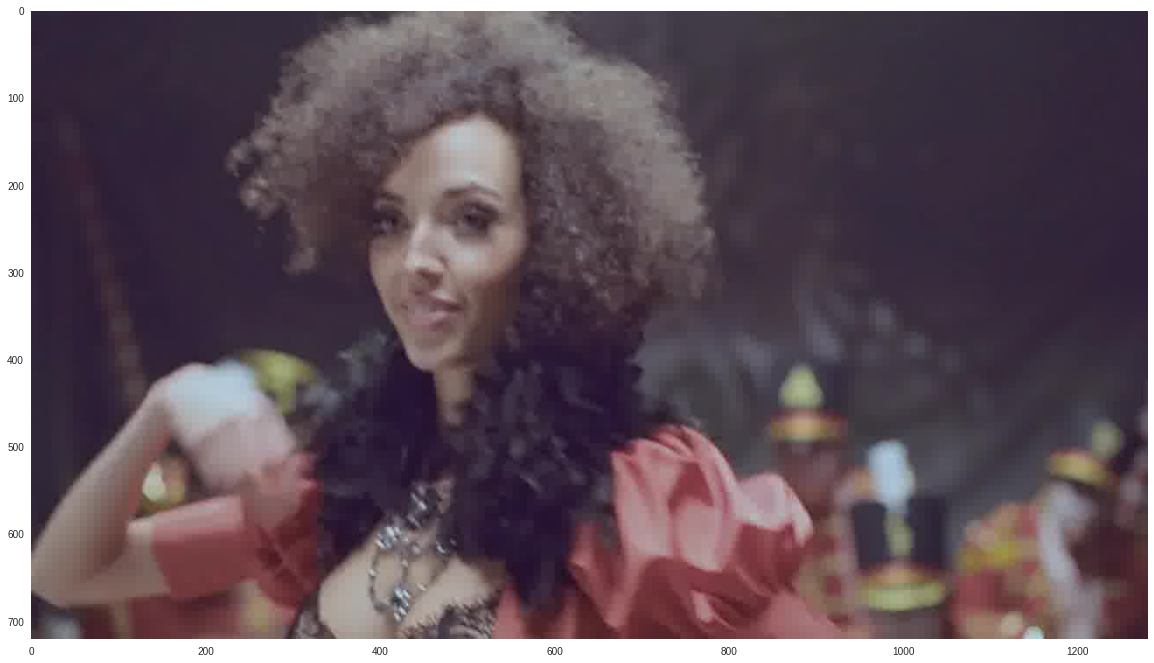

In [115]:
displayframe('Wanted',35)

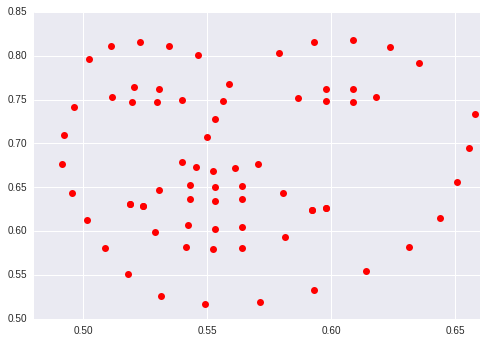

In [141]:
df = getfacelandmarksdf('Wanted')
fc = df[df['0']>0].loc[35].as_matrix()
x = fc[range(0,144,2)]
y = 1-fc[range(1,144,2)]
#plt.axis([0.5,0.7,0.4,0.6])
plt.plot(x[:],y[:],'ro')
#x.shape,y.shape

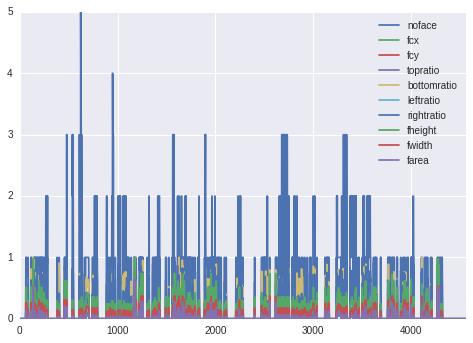

In [142]:
df= getfacedf('Decay')
#df= getfacedf('After_The_Rain')
#df= getfacedf('Attitude_Matters')
#df= getfacedf('Sintel')
t = df #[df['noface']>0][['fcx','fcy']]
plt.figure(figsize=(5,15))
t.plot()

In [143]:
df[df['noface']>1]

noface       fcx       fcy  topratio  bottomratio  leftratio  \
266        2  0.123438  0.061719  0.162500     0.409375   0.868750   
267        2  0.123438  0.061719  0.162500     0.409375   0.093750   
272        2  0.123438  0.061719  0.187500     0.434375   0.756250   
273        2  0.148438  0.074219  0.187500     0.484375   0.726562   
274        2  0.123438  0.061719  0.187500     0.434375   0.743750   
275        2  0.148438  0.074219  0.156250     0.453125   0.742188   
276        2  0.148438  0.074219  0.215625     0.512500   0.126562   
277        2  0.123438  0.061719  0.262500     0.509375   0.193750   
281        2  0.148438  0.074219  0.156250     0.453125   0.742188   
282        2  0.148438  0.074219  0.156250     0.453125   0.742188   
283        2  0.148438  0.074219  0.125000     0.421875   0.742188   
284        2  0.148438  0.061719  0.187500     0.484375   0.876563   
479        3  0.178125  0.089063  0.062500     0.418750   0.620313   
480        3  0.148438  0.074219  0.125000     0.421875   0.621875   
538        3  0.123438  0.061719  0.287500     0.534375   0.593750   
539        2  0.148438  0.074219  0.156250     0.453125   0.637500   
540        2  0.123438  0.061719  0.312500     0.559375   0.206250   
541        2  0.148438  0.074219  0.306250     0.603125   0.562500   
542        3  0.123438  0.061719  0.312500     0.559375   0.556250   
543        3  0.123438  0.061719  0.287500     0.534375   0.556250   
544        2  0.123438  0.061719  0.287500     0.534375   0.181250   
545        2  0.148438  0.074219  0.306250     0.603125   0.576562   
546        2  0.123438  0.061719  0.312500     0.559375   0.568750   
609        2  0.148438  0.074219  0.215625     0.512500   0.546875   
610        3  0.123438  0.061719  0.387500     0.634375   0.293750   
611        2  0.123438  0.061719  0.487500     0.734375   0.018750   
623        5  0.123438  0.061719  0.237500     0.484375   0.543750   
624        4  0.123438  0.061719  0.237500     0.484375   0.593750   
625        4  0.123438  0.061719  0.287500     0.534375   0.531250   
626        4  0.123438  0.061719  0.337500     0.584375   0.518750   
...      ...       ...       ...       ...          ...        ...   
3418       2  0.123438  0.061719  0.112500     0.359375   0.556250   
3428       2  0.123438  0.061719  0.112500     0.359375   0.043750   
3439       2  0.123438  0.061719  0.137500     0.384375   0.068750   
3441       2  0.123438  0.061719  0.387500     0.634375   0.568750   
3513       2  0.178125  0.089063  0.062500     0.418750   0.567187   
3516       2  0.123438  0.061719  0.362500     0.609375   0.393750   
3517       2  0.148438  0.074219  0.337500     0.634375   0.351562   
3521       2  0.148438  0.074219  0.546875     0.843750   0.442188   
3522       2  0.148438  0.074219  0.396875     0.693750   0.412500   
3523       2  0.148438  0.073438  0.515625     0.812500   0.457813   
3524       2  0.148438  0.074219  0.487500     0.784375   0.426563   
3525       2  0.148438  0.074219  0.396875     0.693750   0.426563   
3552       2  0.117188  0.061719  0.000000     0.234375   0.506250   
3561       2  0.148438  0.074219  0.246875     0.543750   0.217188   
3562       2  0.148438  0.074219  0.037500     0.334375   0.142187   
3564       2  0.146875  0.074219  0.278125     0.571875   0.262500   
3565       2  0.146875  0.074219  0.278125     0.571875   0.276562   
3566       2  0.148438  0.074219  0.096875     0.393750   0.201563   
3567       2  0.123438  0.061719  0.062500     0.309375   0.343750   
3568       2  0.123438  0.061719  0.162500     0.409375   0.368750   
3569       2  0.123438  0.061719  0.187500     0.434375   0.368750   
3570       2  0.123438  0.061719  0.112500     0.359375   0.568750   
3579       2  0.123438  0.061719  0.137500     0.384375   0.381250   
3580       2  0.123438  0.061719  0.112500     0.359375   0.543750   
3583       2  0.123438  0.061719  0.162500     0.409375   0.331250   
3584       2  0.

In [144]:
fpsMovie = [['After_The_Rain',23.976],
            ['Attitude_Matters',29.97],
            ['Barely_legal_stories',23.976],
            ['Between_Viewings',25],
            ['Big_Buck_Bunny',24],
            ['Chatter',24],
                ['Cloudland',25],
                ['Damaged_Kung_Fu',25],
                ['Decay',23.976],
                ['Elephant_s_Dream',24],
                ['First_Bite',25],
                ['Full_Service',29.97],
                ['Islands',23.976],
                ['Lesson_Learned',29.97],
                ['Norm',25],
                ['Nuclear_Family',23.976],
                ['On_time',30],
                ['Origami',24],
                ['Parafundit',24],
                ['Payload',25],
                ['Riding_The_Rails',23.976],
                ['Sintel',24],
                ['Spaceman',23.976],
                ['Superhero',29.97],
                ['Tears_of_Steel',24],
                ['The_room_of_franz_kafka',29.786],
                ['The_secret_number',23.976],
                ['To_Claire_From_Sonny',23.976],
                ['Wanted',25],
                ['You_Again',29.97]]

contmoviesfps = pd.DataFrame(fpsMovie,columns=['name','fps'])
contmoviesfps.set_index('name', inplace=True)
contmoviesfps.index.name = None
#contmoviesfps['After_The_Rain']
contmoviesfps['f'] = np.round(contmoviesfps['fps'])


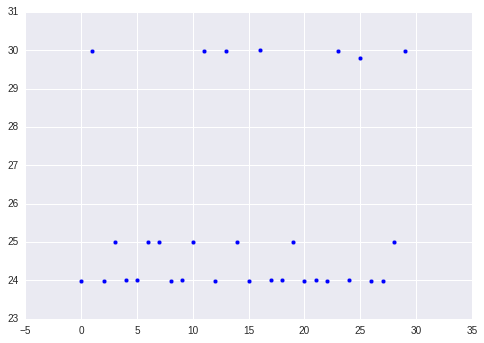

In [15]:
plt.scatter(range(contmoviesfps.shape[0]), contmoviesfps['fps'])
#contmoviesfps.plot()

In [145]:
def getfps(movname):
    return contmoviesfps.loc[movname ]['f']

In [146]:
print contmoviesfps[ contmoviesfps.index == 'You_Again' ]['f']
print getfps('You_Again')

You_Again    30.0
Name: f, dtype: float64
30.0


In [147]:
movgroups_wodecay = {
    0:['You_Again','Damaged_Kung_Fu','The_secret_number','Spaceman'],
    1:['Cloudland','Origami','Riding_The_Rails','Tears_of_Steel','Sintel'],
    2:['On_time','Elephant_s_Dream','Norm','Big_Buck_Bunny','Chatter','Full_Service'],
    3:['Islands','To_Claire_From_Sonny','Nuclear_Family','After_The_Rain','Parafundit'],
    4:['The_room_of_franz_kafka','Attitude_Matters','Lesson_Learned','Superhero'],
    5:['First_Bite','Wanted','Between_Viewings','Barely_legal_stories','Payload']
}

movgroups = {
    0:['You_Again','Damaged_Kung_Fu','The_secret_number','Spaceman'],
    1:['Cloudland','Origami','Riding_The_Rails','Tears_of_Steel','Sintel'],
    2:['On_time','Elephant_s_Dream','Norm','Big_Buck_Bunny','Chatter','Full_Service'],
    3:['Islands','To_Claire_From_Sonny','Nuclear_Family','After_The_Rain','Parafundit'],
    4:['The_room_of_franz_kafka','Attitude_Matters','Lesson_Learned','Superhero'],
    5:['First_Bite','Wanted','Between_Viewings','Barely_legal_stories','Payload'],
    6:['Decay']
}

mov2groups = {
    0:['Decay'],
    1:['You_Again','Damaged_Kung_Fu','The_secret_number','Spaceman'],
    2:['Cloudland','Origami','Riding_The_Rails','Tears_of_Steel','Sintel'],
    3:['On_time','Elephant_s_Dream','Norm','Big_Buck_Bunny','Chatter','Full_Service'],
    4:['Islands','To_Claire_From_Sonny','Nuclear_Family','After_The_Rain','Parafundit'],
    5:['The_room_of_franz_kafka','Attitude_Matters','Lesson_Learned','Superhero'],
    6:['First_Bite','Wanted','Between_Viewings','Barely_legal_stories','Payload'],
}


def gettraintestmovielist(mlist,groups=movgroups):
    testlist = groups[mlist]
    trainlist =[]
    for idx, group in enumerate(groups):
        if idx != mlist:
            for g in groups[idx]:
                trainlist.append(g)
    return trainlist, testlist

''' 
def gettraintest2movielist(foldno,groups=mov2groups):
    if foldno==1:
        mlist=[1,2]
    elif foldno==2:
        mlist=[3,4]
    elif foldno==3:
        mlist=[5,6]
    elif foldno==4:
        mlist=[2,3]
    elif foldno==5:
        mlist=[4,5]
    else:
        mlist=[]
    
    testlist = [] 
    for i in mlist:
        for f in groups[i]:
            testlist.append(f)
            
    trainlist =[]
    for idx, group in enumerate(groups):
        for f in groups[idx]:
            if f not in testlist:
                trainlist.append(f)
                
    return trainlist, testlist
'''

' \ndef gettraintest2movielist(foldno,groups=mov2groups):\n    if foldno==1:\n        mlist=[1,2]\n    elif foldno==2:\n        mlist=[3,4]\n    elif foldno==3:\n        mlist=[5,6]\n    elif foldno==4:\n        mlist=[2,3]\n    elif foldno==5:\n        mlist=[4,5]\n    else:\n        mlist=[]\n    \n    testlist = [] \n    for i in mlist:\n        for f in groups[i]:\n            testlist.append(f)\n            \n    trainlist =[]\n    for idx, group in enumerate(groups):\n        for f in groups[idx]:\n            if f not in testlist:\n                trainlist.append(f)\n                \n    return trainlist, testlist\n'

In [148]:
gettraintestmovielist(2)


(['You_Again',
  'Damaged_Kung_Fu',
  'The_secret_number',
  'Spaceman',
  'Cloudland',
  'Origami',
  'Riding_The_Rails',
  'Tears_of_Steel',
  'Sintel',
  'Islands',
  'To_Claire_From_Sonny',
  'Nuclear_Family',
  'After_The_Rain',
  'Parafundit',
  'The_room_of_franz_kafka',
  'Attitude_Matters',
  'Lesson_Learned',
  'Superhero',
  'First_Bite',
  'Wanted',
  'Between_Viewings',
  'Barely_legal_stories',
  'Payload',
  'Decay'],
 ['On_time',
  'Elephant_s_Dream',
  'Norm',
  'Big_Buck_Bunny',
  'Chatter',
  'Full_Service'])

## Fear Annotations

In [149]:
def getFearDf(movname):
    filename = os.path.join(med2017fearFolder, movname + '-MEDIAEVAL2017-fear.txt')
    annotation = np.genfromtxt(filename, names=True, delimiter='\t', dtype=None)
    df = pd.DataFrame(annotation)
    return df


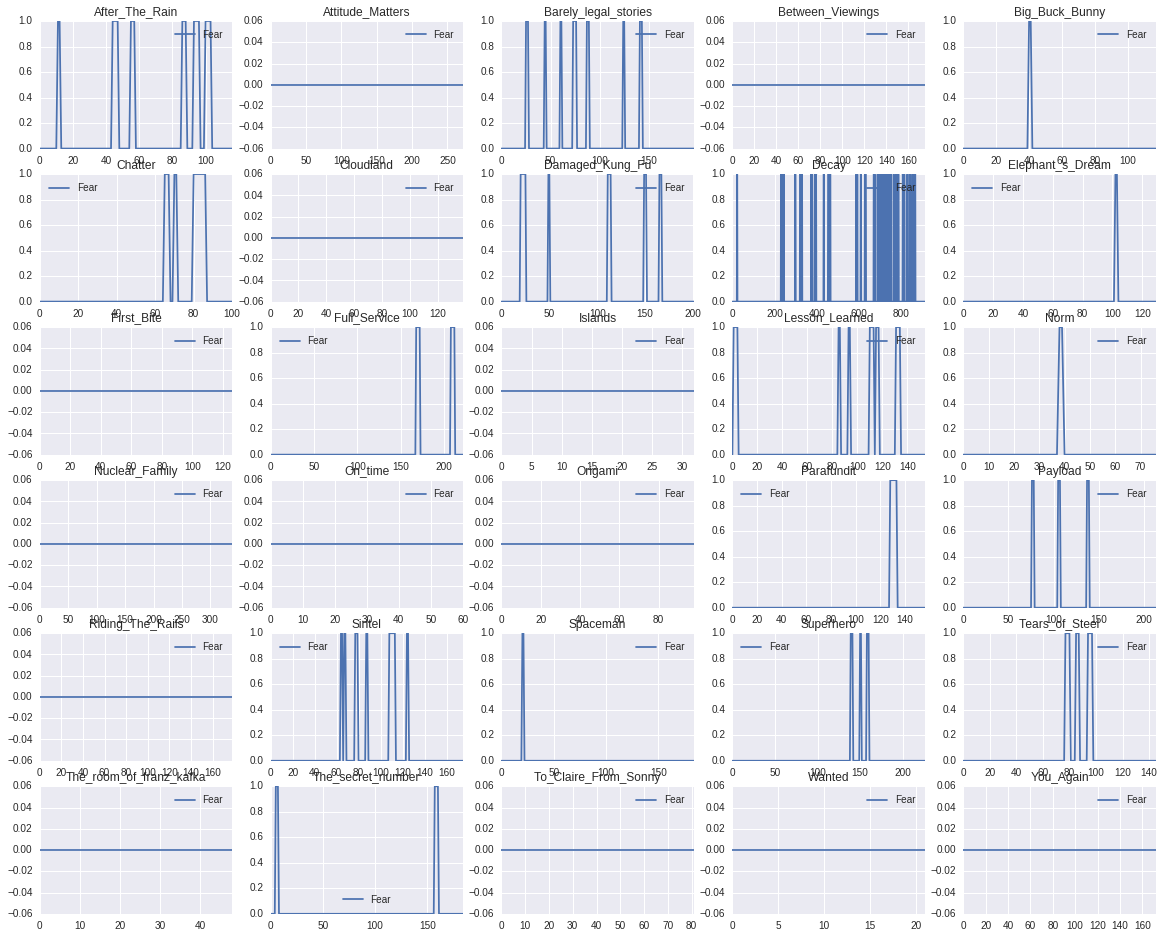

In [150]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getFearDf(mov)
    df[['Fear']].plot(ax=plt.gca(),title=mov)

## Valence Arousal Annotations

In [151]:
def getAnnotationDf(movname,folder=med2017annotationsFolder):
    filename = os.path.join(folder, movname + '-MEDIAEVAL2017-valence_arousal.txt')
    annotation = np.genfromtxt(filename, names=True, delimiter='\t', dtype=None)
    df = pd.DataFrame(annotation)
    return df

In [152]:
def getAnnotationDf(movname,folder=med2017annotationsFolder):
    filename = os.path.join(folder, movname + '-MEDIAEVAL2017-valence_arousal.txt')
    annotation = np.genfromtxt(filename, names=True, delimiter='\t', dtype=None)
    df = pd.DataFrame(annotation)
    return df

In [32]:
df = getAnnotationDf(movieNames[0])
#df.hist(alpha=0.5,bins=50)
df.head()

Id  Time  MeanValence  MeanArousal
0   0     0    -0.000787    -0.162383
1   1     5    -0.000837    -0.184550
2   2    10    -0.000837    -0.205490
3   3    15    -0.000390    -0.207942
4   4    20     0.007565    -0.192212

In [33]:
#df.head()
#df.describe()
df = getAnnotationDf('Islands')
df.head(2)

Id  Time  MeanValence  MeanArousal
0   0     0     0.098658    -0.098712
1   1     5     0.137632    -0.108957

In [34]:
#df = getAnnotationDf(movieNames[0])
#df.hist(alpha=0.5,bins=50)#df.head()
#df.describe()
#df = getAnnotationDf('Islands')
#df.head()

## Visualize 

In [180]:
def avfear(mov = 'Sintel'):
    plt.figure(figsize=(10,8))
    plt.axis([-1, 1500, -1, 1])
    avdf = getAnnotationDf(mov)
    avdf[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='-',title=mov)
    feardf = getFearDf(mov)
    feardf[['Fear']].plot(ax=plt.gca(),title=mov,style='-')

In [181]:
#avfear('Islands')

In [182]:
fdf= getFearDf('Islands')
len(fdf[fdf['Fear']>0])

0

In [185]:
fearfull = []
for i in movieNames:
    fdf = getFearDf(i)
    if len(fdf[fdf['Fear'] == 1 ]) > 0:
        fearfull.append(i)

len(fearfull),fearfull
#for i in fearfull:
#    avfear(i)

(17,
 ['After_The_Rain',
  'Barely_legal_stories',
  'Big_Buck_Bunny',
  'Chatter',
  'Damaged_Kung_Fu',
  'Decay',
  'Elephant_s_Dream',
  'Full_Service',
  'Lesson_Learned',
  'Norm',
  'Parafundit',
  'Payload',
  'Sintel',
  'Spaceman',
  'Superhero',
  'Tears_of_Steel',
  'The_secret_number'])

# Shot boundary detections

In [153]:
def getShotDf(movie,folder=pathcontfeatures):
    filename =  folder + movie + '.mp4-shot-times.txt'
    shotarray = np.genfromtxt(filename, delimiter=' ',dtype=int)
    df = pd.DataFrame(shotarray,columns=['cut'])
    fps=getfps(movie)
    #fps
    df['time'] = df['cut']*1. / fps
    return df

In [154]:
x = getShotDf('Sintel')['time']
df = getAnnotationDf('Sintel')
getfps('Sintel')

24.0

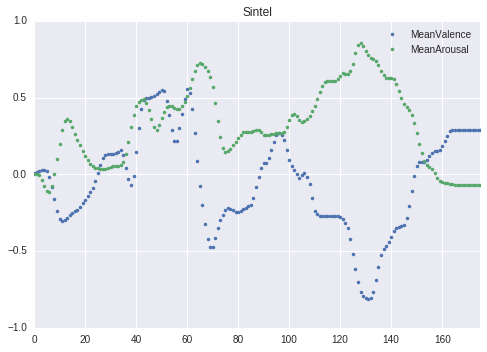

In [155]:
movname = 'Sintel'
df = getAnnotationDf(movname)
df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='.',title=movname)


In [156]:
len(x),df.shape

(227, (176, 4))

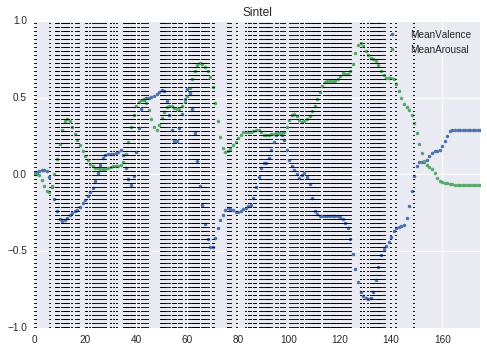

In [159]:
#plt.scatter(x,np.ones(len(x)))
movname = 'Sintel'
df = getAnnotationDf(movname)
df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='.',title=movname)
cuts = getShotDf(movname)['time']
for i in range(len(cuts)):
    x=cuts[i]/5
    plt.axvline(x,linestyle=':',color='black')

#plt.title('AV plor with shot times')
#plt.tight_layout()

In [51]:
#df.head(10)
#cuts.head()

In [52]:
#tin = pd.DataFrame(np.arange(100),columns=['Id'])
#tin['Time'] = tin['Id']*5
#tin.head(10), 
#tin.rolling(window=10).mean()[8:]
#tin.head(15)
#ten seconds-segments sliding over the whole movie with a shift of 5 seconds

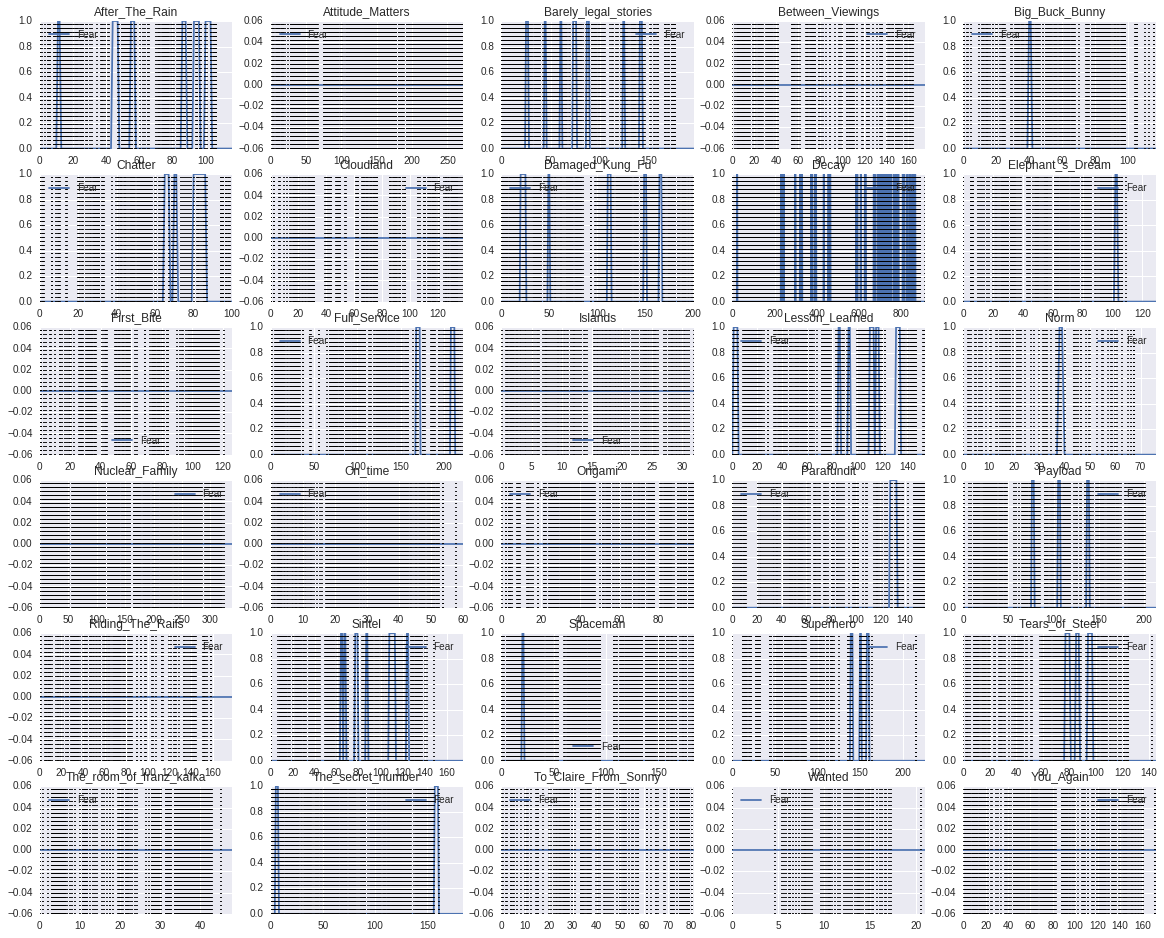

In [121]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getFearDf(mov)
    df[['Fear']].plot(ax=plt.gca(),title=mov)
    cuts = getShotDf(mov)['time']
    for i in range(len(cuts)):
        x=cuts[i]/5   ## conversion of time to sliding windows with 5 
        plt.axvline(x,linestyle=':',color='black')


# lets now take a look and see if its doing something sensible
import matplotlib
import matplotlib.pyplot as plt

fig,ax1 = plt.subplots(1,1)
#ax1.plot(data['Close'])
y = ax1.get_ylim()
ax1.set_ylim(y[0] - (y[1]-y[0])*0.4, y[1])

ax2 = ax1.twinx()
ax2.set_position(matplotlib.transforms.Bbox([[0.125,0.1],[0.9,0.32]]))
#ax2.plot(data['Buy'], color='#77dd77')
#ax2.plot(data['Sell'], color='#dd4444')

## Valence, Arousal histogram plots for Dev-Set

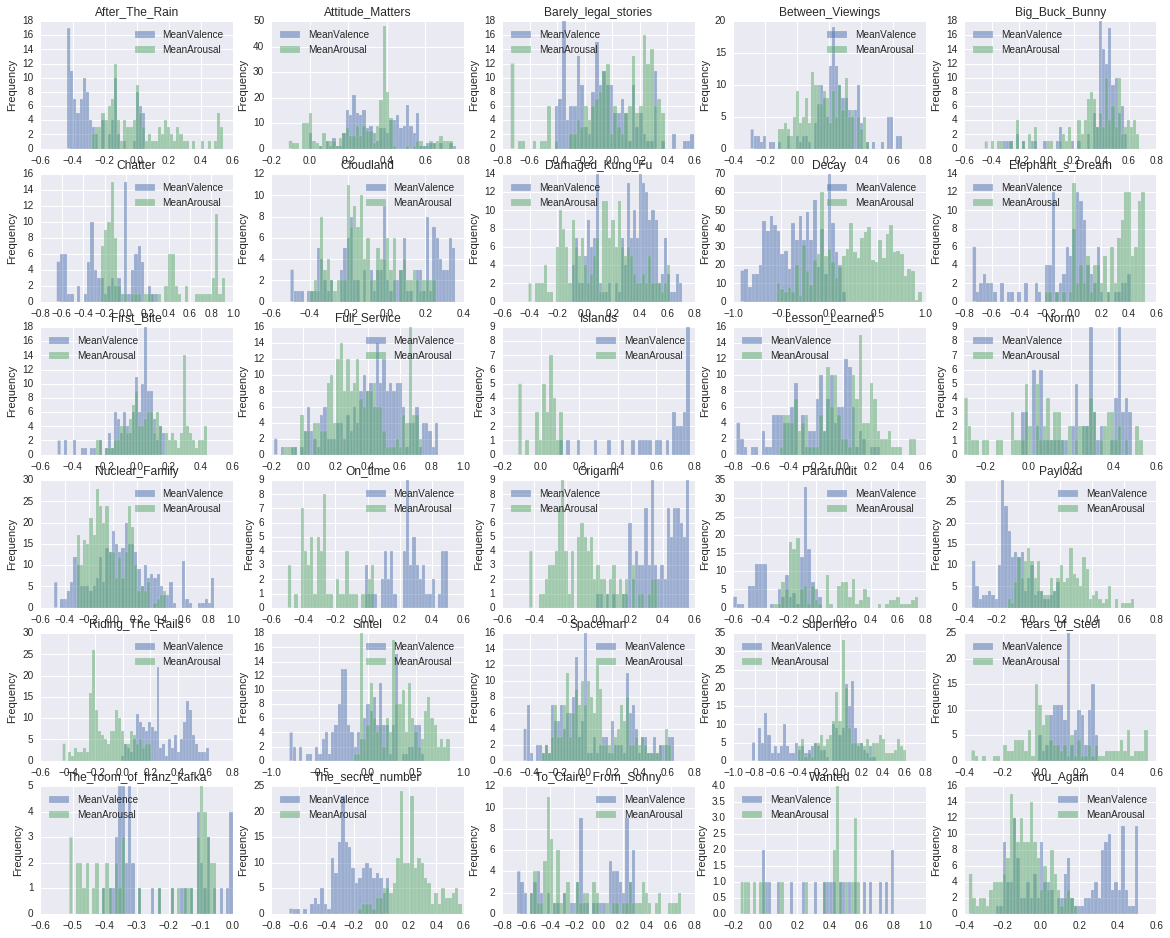

In [58]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)    
    df = getAnnotationDf(mov)
    df[['MeanValence','MeanArousal']].plot.hist(ax=plt.gca(),title=mov,alpha=0.5,bins=50)

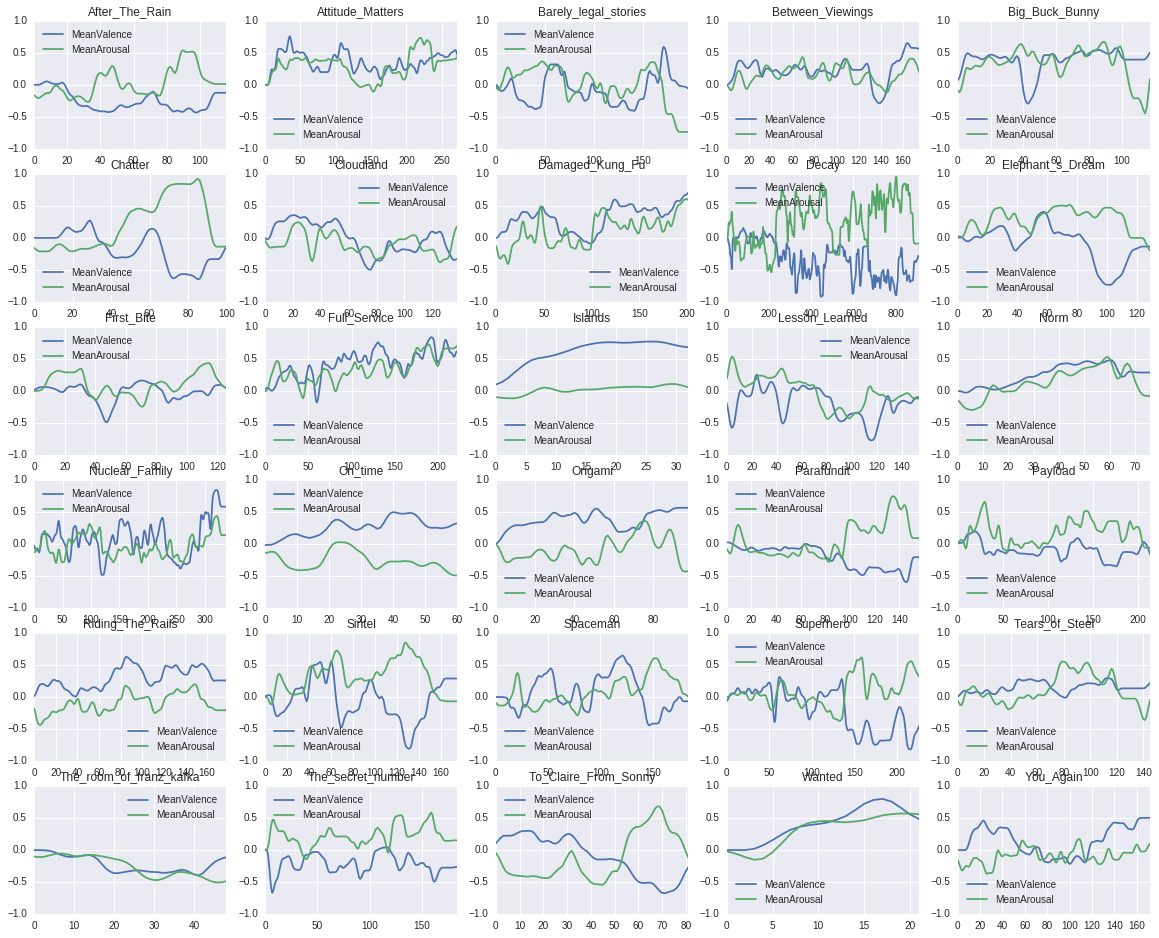

In [23]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    plt.axis([-1, 1500, -1, 1])
    dfa = getAnnotationDf(mov)
    dfa[['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)


## Valence , Arousal plots for Dev-Set

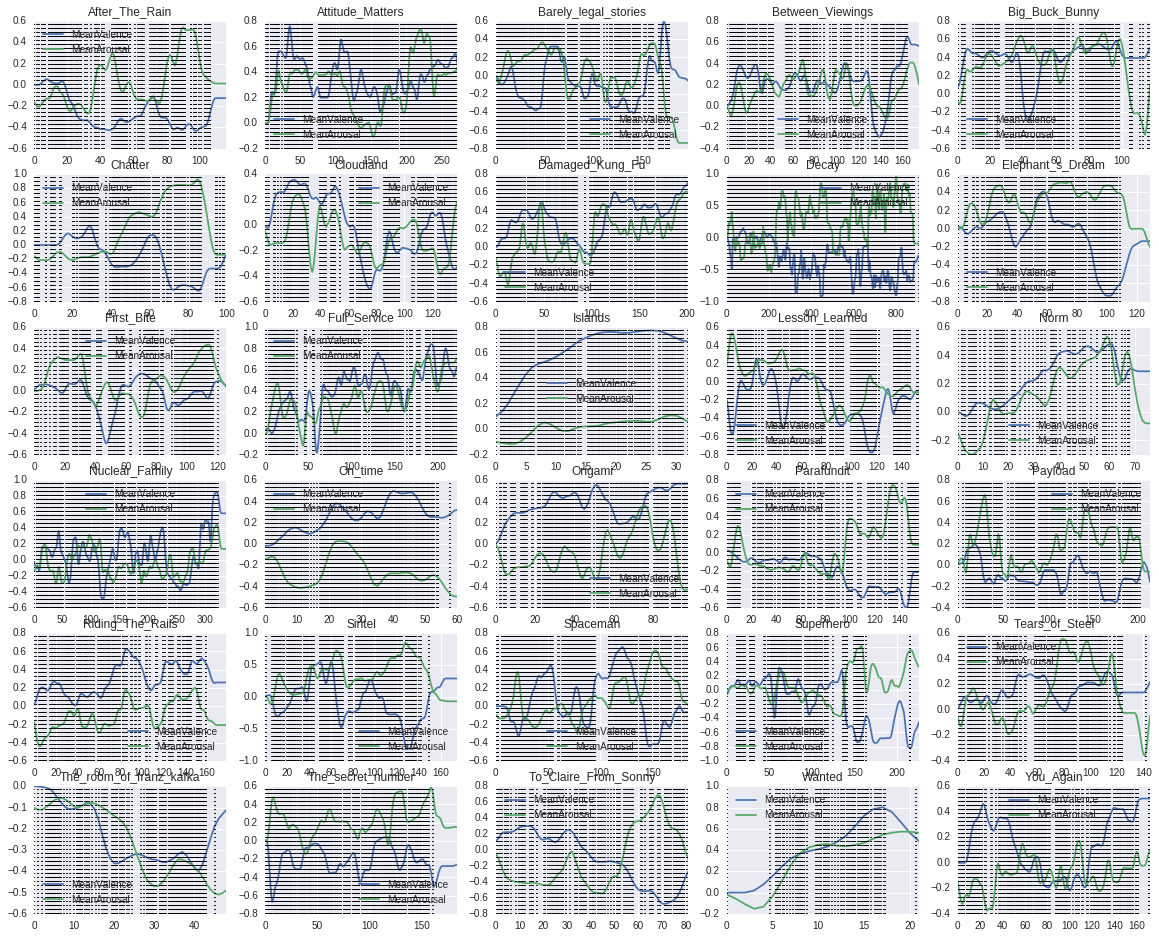

In [160]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getAnnotationDf(mov)
    df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)
    cuts = getShotDf(mov)['time']
    for i in range(len(cuts)):
        x=cuts[i]/5
        plt.axvline(x,linestyle=':',color='black')

In [170]:
feardf = getFearDf(mov)
farr = feardf[feardf['Fear']>0]['Id'].as_matrix()
farr

array([ 11,  12,  44,  45,  46,  47,  55,  56,  57,  86,  87,  88,  93,
        94,  95,  96, 100, 101, 102, 103])

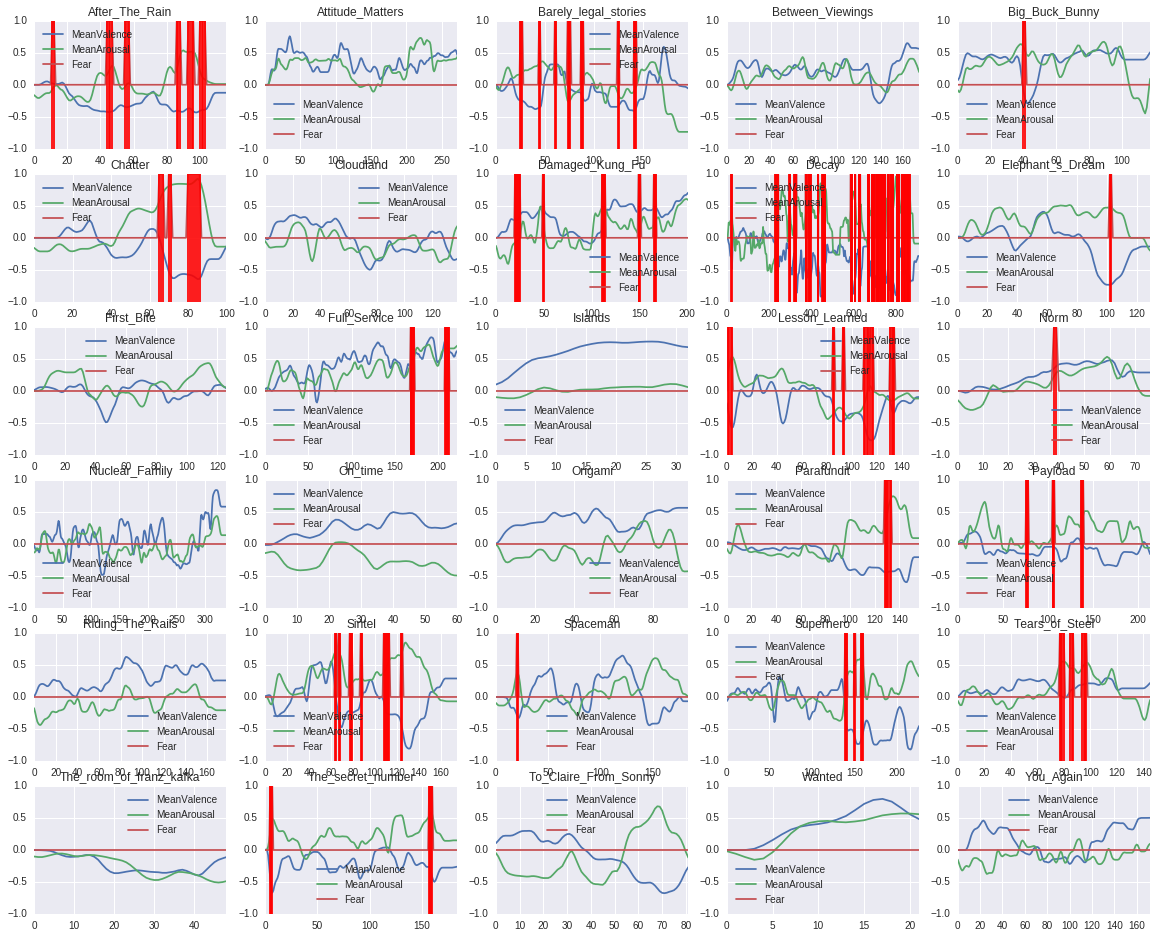

In [176]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    plt.axis([-1, 1500, -1, 1])
    df = getAnnotationDf(mov)
    feardf = getFearDf(mov)
    
    df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)
    feardf[['Fear']].plot(ax=plt.gca(),title=mov)
    farr = feardf[feardf['Fear']>0]['Id'].as_matrix()
    for i in farr:
        plt.axvline(x=i,linestyle='-',color='red')




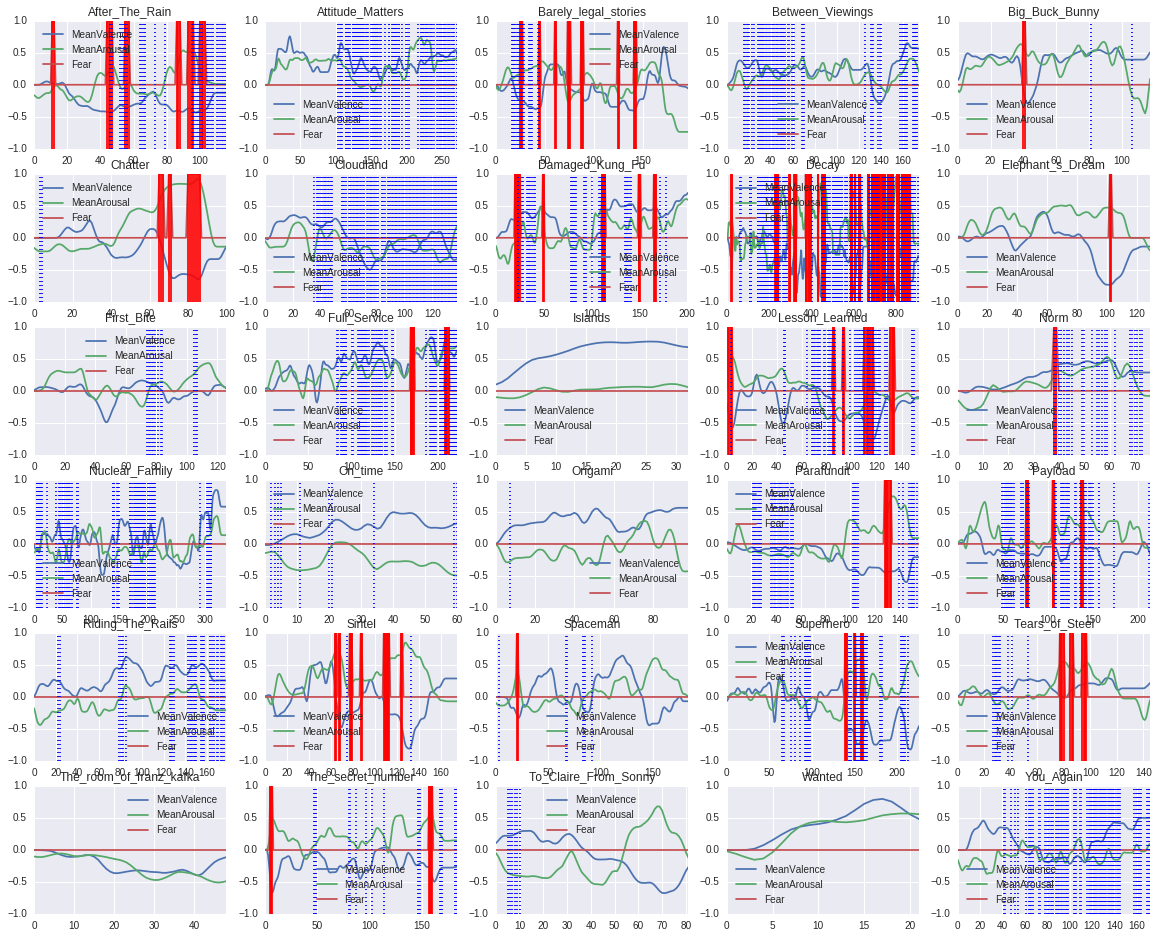

In [378]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    plt.axis([-1, 1500, -1, 1])
    df = getAnnotationDf(mov)
    feardf = getFearDf(mov)
    
    df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)
    feardf[['Fear']].plot(ax=plt.gca(),title=mov)
    farr = feardf[feardf['Fear']>0]['Id'].as_matrix()
    for i in farr:
        plt.axvline(x=i,linestyle='.-',color='red')

    fdf = getfacelandmarksdf(mov)
    fc = list(fdf[fdf['0']>0].index)
    for i in fc:
        plt.axvline(x=i,linestyle=':',color='blue')
    

## Audio Features


In [195]:
def getAudioDf(moviename,folder=med2017audiofolder):
    if 'TestSet' in folder:
        files = glob.glob(folder+moviename+'/audio_features/*.csv')
    else:
        files = glob.glob(folder+moviename+'/*.csv')
    files = sorted(files)
    files
    alist = []
    for fname in files:
        f=open(fname,'r')
        h = []
        for l in f :
            if '@attribute' in l:
                h.append(l.split()[1])
            elif l == '\n':
                l
            elif l[0] =='@':
                l
            else:
                alist.append(map(float,l.split(',')[1:])) #first attribute is string ,skipped
        f.close()
    
    return pd.DataFrame(alist,columns=h[1:])

## Visual Features

In [196]:
visual_feat = ['acc', 'cedd', 'cl', 'eh', 'fc6', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]
visual_feat_wofc16 = ['acc', 'cedd', 'cl', 'eh', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]

In [197]:
def getVisFeatureDf(moviename,typename,folder=med2017visualFeaturesfolder):
    files = glob.glob(folder+moviename+'/'+typename+'/*.txt')
    files = sorted(files)
    alist = []
    for fname in files:
        f=open(fname,'r')
        for l in f:
            alist.append(map(float,l.split(',')))
        f.close()
    return pd.DataFrame(alist)

def getAvgVisFeatureDf(moviename,typename,folder=med2017visualFeaturesfolder):
    df = getVisFeatureDf(moviename,typename,folder)
    dfwindow = df.rolling(10).mean()[9::5] ############### start with 9
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    return dfwindow

def getAvgVisFeatListDf(moviename,featlist,folder=med2017visualFeaturesfolder):
    df = getVisFeatureDf(moviename,featlist[0],folder)
    for feat in featlist[1:]:
        tdf = getVisFeatureDf(moviename,feat,folder)
        df = pd.concat([df,tdf],axis=1)
    
    dfwindow = df.rolling(10).mean()[9::5] ############### start with 9
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    dfwindow.columns=list(range(len(dfwindow.columns)))
    return dfwindow

In [198]:
sum([len(getAnnotationDf(m)) for m in movieNames ])

5274

In [199]:
sum([len(getAudioDf(m)) for m in movieNames ])

5264

In [200]:
sum([len(getVisFeatureDf(m,'cl')) for m in movieNames ])

26589

In [201]:
sum([len(getAvgVisFeatureDf(m,'cl')) for m in movieNames ])

5276

In [379]:
df = getVisFeatureDf(movieNames[0],'cl')
#df = getAvgVisFeatureDf(movieNames[0],'cl')
#df = getAvgVisFeatListDf(movieNames[0],['cl','eh'])
#df.hist()
#df.head(10)

In [72]:
#df = getAvgVisFeatListDf(movieNames[0],['fc6'])
#df = getVisFeatureDf(movieNames[0],'fc6')
#df.describe()

## Low Level Cinematographic Features
fps değerlerine göre, feature çıkarma key frame seçme ve averaging tekrar yapılacak.

In [202]:
def getLowFeatureDf(movname,folder=pathcontfeatures):
    fname = movname +'.mp4continous_features.txt'
    
    df = pd.DataFrame(np.genfromtxt( os.path.join(folder,fname)))
    df.columns = ['time','framemean','huemean','satmean','valmean', 'redmean','greenmean','bluemean', 'lummean','motion']
    return df

def getLowFeature10SecDf(movname):
    pdf = getLowFeatureDf(movname)
    
    dfwindow = pdf.rolling(10).mean()[9::5]
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    dfwindow.drop('time',axis=1,inplace=True)
    return dfwindow

def getMovieListLowFeatFearDf(movieNames):
    X = getLowFeature10SecDf(movieNames[0])
    y = getFearDf(movieNames[0]).Fear[:len(X)]

    for mov in movieNames[1:]:
        tX=getLowFeatureDf(mov)
        ty=getFearDf(mov).Fear[:len(tX)]
        X = X.append(tX)
        y = y.append(ty)
        if (X.shape != y.shape):
            print mov, X.shape, y.shape
    return X,y

In [203]:
#getLowFeatureDf(movieNames[1]).head(10)[2::2]

In [380]:
#print getLowFeatureDf(movieNames[1]).head(10)
#print getLowFeatureDf(movieNames[1]).head(10).mean()
#print getLowFeature10SecDf(movieNames[1]).head(10)

## Face Features 

In [205]:
def getFaceFeature(movie):
    df  = getfacedf(movie)
    dfwindow = df.rolling(window=10).mean()[10::5]
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    return dfwindow

In [206]:
getFaceFeature('Islands').head()

noface           fcx       fcy  topratio  bottomratio  leftratio  \
0     0.0  0.000000e+00  0.000000  0.000000     0.000000   0.000000   
1     0.2  1.939815e-02  0.010937  0.086667     0.125463   0.065937   
2     0.2  1.939815e-02  0.010937  0.086667     0.125463   0.065937   
3     0.0  1.387779e-18  0.000000  0.000000     0.000000   0.000000   
4     0.0  1.387779e-18  0.000000  0.000000     0.000000   0.000000   

   rightratio       fheight    fwidth     farea  
0    0.000000  0.000000e+00  0.000000  0.000000  
1    0.087813  3.879630e-02  0.021875  0.004761  
2    0.087813  3.879630e-02  0.021875  0.004761  
3    0.000000  2.775558e-18  0.000000  0.000000  
4    0.000000  2.775558e-18  0.000000  0.000000

In [208]:
def getFaceLandmarkFeature(movie):
    df  = getfacelandmarksdf(movie)
    dfwindow = df.rolling(window=10).mean()[10::5]
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    return dfwindow

In [209]:
getFaceLandmarkFeature('Islands').head()

0    1    2    3    4    5    6    7    8    9 ...   134  135  136  137  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   138  139  140  141  142  143  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 144 columns]

In [321]:
getfacelandmarksdf('After_The_Rain')

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 144 columns]

## Train and Test set creation

In [230]:
def getFeatureswFearMovieDf(movie,featlist=visual_feat_wofc16):
    Xv = getAvgVisFeatListDf(movie,featlist)
    Xa = getAudioDf(movie)
    Xd = getAvgVisFeatListDf(movie,['fc6'])
    Xl = getLowFeature10SecDf(movie)
    Xf = getFaceFeature(movie)
    Xfl = getFaceLandmarkFeature(movie)
    y = getFearDf(movie)[['Fear']]

    return Xv,Xa,Xd,Xl,Xf,Xfl,y

In [250]:
getFaceFeature('Chatter')

noface           fcx           fcy      topratio   bottomratio  \
0       0.2  5.551471e-02  2.828125e-02  5.183824e-02  1.628676e-01   
1       0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
2       0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
3       0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
4       0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
5       0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
6       0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
7       0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
8       0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
9       0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
10      0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
11      0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
12      0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
13      0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
14      0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
15      0.0  2.775558e-18  1.387779e-18  0.000000e+00  2.220446e-17   
16      0.4  3.198529e-02  1.351563e-02  1.180147e-01  1.819853e-01   
17      1.3  1.233456e-01  5.218750e-02  3.698529e-01  6.165441e-01   
18      1.2  1.297794e-01  5.500000e-02  3.444853e-01  6.040441e-01   
19      0.3  3.841912e-02  1.632812e-02  9.264706e-02  1.694853e-01   
20      0.0  0.000000e+00  0.000000e+00  4.440892e-17  0.000000e+00   
21      0.4  7.022059e-02  2.984375e-02  1.253676e-01  2.658088e-01   
22      0.8  1.455882e-01  6.398438e-02  2.066176e-01  4.977941e-01   
23      0.7  1.044118e-01  4.648438e-02  1.459559e-01  3.547794e-01   
24      0.7  1.090074e-01  4.632813e-02  9.852941e-02  3.165441e-01   
25      0.6  1.216912e-01  5.164063e-02  5.294118e-02  2.963235e-01   
26      0.7  1.509191e-01  6.414063e-02  1.125000e-01  4.143382e-01   
27      0.8  1.683824e-01  7.164063e-02  1.661765e-01  5.029412e-01   
28      0.8  1.659926e-01  7.054688e-02  1.566176e-01  4.886029e-01   
29      0.9  1.700368e-01  7.320313e-02  1.117647e-01  4.518382e-01   
..      ...           ...           ...           ...           ...   
71      0.9  2.759191e-01  1.182813e-01  6.397059e-02  6.158088e-01   
72      0.8  2.430147e-01  1.034375e-01  6.139706e-02  5.474265e-01   
73      0.3  9.136029e-02  3.890625e-02  3.051471e-02  2.132353e-01   
74      0.0  1.665335e-17  3.885781e-17  1.137979e-16  0.000000e+00   
75      0.2  6.029412e-02  2.562500e-02  2.794118e-02  1.485294e-01   
76      0.3  9.632353e-02  4.093750e-02  3.933824e-02  2.319853e-01   
77      0.1  3.602941e-02  1.531250e-02  1.139706e-02  8.345588e-02   
78      0.0  1.110223e-17  3.885781e-17  1.096345e-16  0.000000e+00   
79      0.4  5.808824e-02  2.468750e-02  6.470588e-02  1.808824e-01   
80      0.7  1.016544e-01  4.320313e-02  1.250000e-01  3.283088e-01   
81      0.8  1.161765e-01  4.937500e-02  2.029412e-01  4.352941e-01   
82      0.7  1.016544e-01  4.320313e-02  1.602941e-01  3.636029e-01   
83      0.6  8.713235e-02  3.703125e-02  1.235294e-01  2.977941e-01   
84      0.9  1.707721e-01  7.273438e-02  1.904412e-01  5.319853e-01   
85      0.8  1.795956e-01  7.648438e-02  1.341912e-01  4.933824e-01   
86      0.3  6.691176e-02  2.843750e-02  4.963235e-02  1.834559e-01   
87      0.0  0.000000e+00  1.665335e-17  6.800116e-17  2.109424e-16   
88      0.0  0.000000e+00  1.665335e-17  6.800116e-17  2.109424e-16   
89      0.0  0.000000e+00  1.665335e-17  6.800116e-17  2.109424e-16   
90      0.0  0.000000e+00  1.665335e-17  6.800116e-17  2.109424e-16   
91      0.0  0.000000e+00  1.665335e-17  6.800116e-17  2.109424e-16   
92      0.0  0.000000e+00  1.665335e-17  6.800116e-17  2.109424e-16   
93      0.0  0.000000e+00  1.665335e-17  6.800116e-17  2.109424e-16   
94      0.0  0.000000e+00  1.665335e-17  6.800116e-17  2.109424e-16   
95      0.2  6.194853e-02  3.

In [381]:
#lambda a: print(a.shape) for a in [Xv,Xa,Xd,Xd,Xl,Xf,y]
#Xv.shape,Xa.shape,Xd.shape,Xl.shape,Xf.shape,Xfl.shape,y.shape

In [251]:
def getFeatureswFearDf(movieNames,featlist=visual_feat_wofc16):
    print movieNames[0]
    Xv = getAvgVisFeatListDf(movieNames[0],featlist)
    Xa = getAudioDf(movieNames[0])
    Xd = getAvgVisFeatListDf(movieNames[0],['fc6'])
    Xl = getLowFeature10SecDf(movieNames[0])
    Xf = getFaceFeature(movieNames[0])
    Xfl = getFaceLandmarkFeature(movieNames[0])
    y = getFearDf(movieNames[0])[['Fear']]
    
    
    lenlist = [len(Xv),len(Xa), len(Xd), len(Xl),len(Xf),len(Xfl),len(y)]
    mlen = min(lenlist)
    
    Xv = Xv[:mlen]
    Xa = Xa[:mlen]
    Xd = Xd[:mlen]
    Xl = Xl[:mlen]
    Xf = Xf[:mlen]
    Xfl = Xfl[:mlen]
    y  = y[:mlen]
    
    for mov in movieNames[1:]:
        print mov
        tXv = getAvgVisFeatListDf(mov,featlist)
        tXa = getAudioDf(mov)
        tXd = getAvgVisFeatListDf(mov,['fc6'])
        tXl = getLowFeature10SecDf(mov)
        tXf = getFaceFeature(mov)
        tXfl = getFaceLandmarkFeature(mov)
        ty = getFearDf(mov)[['Fear']]
        
        mlen = min(len(tXv),len(tXa),len(tXd),len(tXl),len(tXf),len(tXfl),len(ty))
        tXv = tXv[:mlen]
        tXa = tXa[:mlen]
        tXd = tXd[:mlen]
        tXl = tXl[:mlen]
        tXf = tXf[:mlen] 
        tXfl = tXfl[:mlen]
        ty = ty[:mlen]
        
        Xv  = Xv.append(tXv)
        Xa  = Xa.append(tXa)
        Xd = Xd.append(tXd)
        Xl = Xl.append(tXl)
        Xf = Xf.append(tXf)
        Xfl = Xfl.append(tXfl)
        y  = y.append(ty)
        
    return Xv,Xa,Xd,Xl,Xf,Xfl,y

In [252]:
def df2mat(df):
    return df.as_matrix().reshape((len(df),))


In [253]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
#from sklearn.grid_search import GridSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#from sklearn import cross_validation
from sklearn import metrics   #Additional scklearn functions

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams


In [221]:
import sklearn
sklearn.__version__

'0.19.1'

# Classification work

In [222]:
def getGridCV(pipe,paramgirid,Xtrain,ytrain): # scoring ?
    grid = GridSearchCV(pipe, param_grid, cv=5,n_jobs=125)
    grid.fit(Xtrain,ytrain)
    
    return grid


In [223]:
def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % 
              (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## Train and Test set selection in development set

In [382]:
#trainlist, testlist=gettraintestmovielist(2,mov2groups) # index 2 olanları test , diğerlerini train yapan fonksiyon
trainlist, testlist= fearfull[:12],fearfull[12:]
trainlist,testlist


(['After_The_Rain',
  'Barely_legal_stories',
  'Big_Buck_Bunny',
  'Chatter',
  'Damaged_Kung_Fu',
  'Decay',
  'Elephant_s_Dream',
  'Full_Service',
  'Lesson_Learned',
  'Norm',
  'Parafundit',
  'Payload'],
 ['Sintel', 'Spaceman', 'Superhero', 'Tears_of_Steel', 'The_secret_number'])

In [383]:
tXv,tXa,tXd,tXl,tXf,tXfl,ty = getFeatureswFearDf(trainlist)
print(tXv.shape,tXa.shape,tXd.shape,tXl.shape,tXfl.shape,ty.shape)

After_The_Rain
Barely_legal_stories
Big_Buck_Bunny
Chatter
Damaged_Kung_Fu
Decay
Elephant_s_Dream
Full_Service
Lesson_Learned
Norm
Parafundit
Payload
((2597, 1271), (2597, 1583), (2597, 4096), (2597, 9), (2597, 144), (2597, 1))


In [384]:
(len(ty[ty['Fear']==1])),len(ty[ty['Fear']==0]),float(len(ty[ty['Fear']==1]))/len(ty[ty['Fear']==0])

(238, 2359, 0.10089020771513353)

In [385]:
testXv, testXa, testXd,testXl, testXf, testXfl, testy = getFeatureswFearDf(testlist)
print(testXv.shape, testXa.shape,testXd.shape, testXl.shape,testXf.shape,testXfl.shape, testy.shape)

Sintel
Spaceman
Superhero
Tears_of_Steel
The_secret_number
((917, 1271), (917, 1583), (917, 4096), (917, 9), (917, 10), (917, 144), (917, 1))


In [386]:
(len(testy[testy['Fear']==1])),len(testy[testy['Fear']==0]),float(len(testy[testy['Fear']==1]))/len(testy[testy['Fear']==0])

(45, 872, 0.051605504587155966)

## Class imbalance 

In [393]:
"""
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

# Apply regular SMOTE
kind = ['regular', 'borderline1', 'borderline2', 'svm']
sm = [SMOTE(kind=k) for k in kind]
X_resampled = []
y_resampled = []
X_res_vis = []
for method in sm:
    X_res, y_res = method.fit_sample(X, y)
    X_resampled.append(X_res)
    y_resampled.append(y_res)
    X_res_vis.append(pca.transform(X_res))

"""
from imblearn.over_sampling import SMOTE

sm = SMOTE(ratio='auto', kind='regular')
X_resampled, y_resampled = sm.fit_sample(tXl,df2mat(ty))

tXl.shape,ty.shape, X_resampled.shape, y_resampled.shape

((2597, 9), (2597, 1), (4718, 9), (4718,))

# Grid-Search cross validation Logistic Regression

In [ ]:
%%time

pipe = make_pipeline(LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid_visual = GridSearchCV(pipe, param_grid, cv=5,n_jobs=-1)
grid_visual.fit(tXv, ty)

grid_audio = GridSearchCV(pipe, param_grid, cv=5,n_jobs=-1)
grid_audio.fit(tXa, ty)


In [ ]:
print("Best cross-validation score: {:.2f}".format(grid_visual.best_score_))
print("Best parameters: ", grid_visual.best_params_)

print("Best cross-validation score: {:.2f}".format(grid_audio.best_score_))
print("Best parameters: ", grid_audio.best_params_)


Deep Neural Network feature fc6 produces the highest recall rate with logistic regression classifier

In [ ]:
predictionsv = LogisticRegression(C=0.001).fit(tXv, ty).predict(testXv)
predictionsa = LogisticRegression(C=0.001).fit(tXa, ty).predict(testXa)
predictionsd = LogisticRegression(C=0.001).fit(tXd, ty).predict(testXd)
predictionsl = LogisticRegression(C=0.001).fit(tXl, ty).predict(testXl)
predictionsf = LogisticRegression(C=0.001).fit(tXf, ty).predict(testXf)

print('Visual Features:\n {}\n'.format(metrics.classification_report(predictionsv,testy)))
print('Audio:\n {}\n'.format(metrics.classification_report(predictionsa,testy))) 
print('Deep:\n {}\n'.format(metrics.classification_report(predictionsd,testy)))
print('Low Level:\n {}\n'.format(metrics.classification_report(predictionsl,testy))) 
print('Face:\n {}\n'.format(metrics.classification_report(predictionsf,testy))) 

## Grid search for SVC , RF and GB with lowlevel features 

In [394]:
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', SVC())])

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 1, 10],
     'classifier__C': [0.01, 1, 10,100]}]


grid = GridSearchCV(pipe, param_grid, cv=5,n_jobs=4)
grid.fit(tXl,ty)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))


Best params:
{'classifier__gamma': 0.001, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'classifier': SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 0.01}

Best cross-validation score: 0.91


In [398]:
#grid.grid_scores_, grid.best_params_, grid.best_score_

In [404]:
pipe = Pipeline([('classifier', RandomForestClassifier())])

pipe_low_fear = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=30, 
                                   min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_features='auto', 
                                   max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, bootstrap=True, oob_score=False, 
                                   n_jobs=1, random_state=None, verbose=0, warm_start=False, 
                                   class_weight=None))

param_grid = [
    {'classifier__n_estimators': [6,8,9],
     'classifier__max_depth': [10,20,30]
    }]


grid = GridSearchCV(pipe, param_grid, cv=5,n_jobs=4)
grid.fit(tXl,ty)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

Best params:
{'classifier__n_estimators': 8, 'classifier__max_depth': 10}

Best cross-validation score: 0.90


/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


## pipelines with best classifiers (SVC)

In [364]:
def evaluate_pipe(pipe,trainX,trainy,testX,testy):
    
    ytrainarray = trainy.as_matrix().reshape((len(trainy),))
    ytestarray = testy.as_matrix().reshape((len(testy),))

    pipe.fit(trainX, ytrainarray)
    y_pred = pipe.predict(testX)
    
    print("Train score: {:.2f}".format(pipe.score(trainX, ytrainarray)))
    print("Test score: {:.2f}".format(pipe.score(testX, ytestarray)))

    print(metrics.classification_report(y_pred,testy))
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(ytestarray, y_pred)
    print "Precision : %.4g" % metrics.precision_score(ytestarray, y_pred)
    print "Recall : %.4g" % metrics.recall_score(ytestarray, y_pred)
        
    return pipe

In [366]:
pipe_visual_fear = make_pipeline(
    StandardScaler(),
    PCA(n_components=20),
    SVC(C=1 , cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False))
    
pvisfear = evaluate_pipe(pipe_visual_fear,tXv, ty,testXv,testy)

Train score: 0.91
Test score: 0.95
             precision    recall  f1-score   support

          0       1.00      0.95      0.97       732
          1       0.00      0.00      0.00         0

avg / total       1.00      0.95      0.97       732


Model Report
Accuracy : 0.9481
Precision : 0
Recall : 0


In [367]:
pipe_audio_fear = make_pipeline(
    StandardScaler(),
    PCA(n_components=20),
    SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False))

paudfear = evaluate_pipe(pipe_audio_fear,tXa, ty,testXa,testy)

Train score: 0.91
Test score: 0.95
             precision    recall  f1-score   support

          0       1.00      0.95      0.97       732
          1       0.00      0.00      0.00         0

avg / total       1.00      0.95      0.97       732


Model Report
Accuracy : 0.9481
Precision : 0
Recall : 0


In [369]:

pipe_deep_fear = make_pipeline(
    StandardScaler(),
    PCA(n_components=20),
    SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False))

pdeepfear = evaluate_pipe(pipe_deep_fear,tXd, ty,testXd,testy)


Train score: 1.00
Test score: 0.95
             precision    recall  f1-score   support

          0       1.00      0.95      0.97       732
          1       0.00      0.00      0.00         0

avg / total       1.00      0.95      0.97       732


Model Report
Accuracy : 0.9481
Precision : 0
Recall : 0


In [410]:
pipe_low_fearSVC =  make_pipeline(StandardScaler(),
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))

plowfear = evaluate_pipe(pipe_low_fear,tXl, ty,testXl,testy)

Train score: 0.93
Test score: 0.95
             precision    recall  f1-score   support

          0       1.00      0.95      0.97       913
          1       0.00      0.00      0.00         4

avg / total       0.99      0.95      0.97       917


Model Report
Accuracy : 0.9466
Precision : 0
Recall : 0


In [413]:
pipe_low_fear = make_pipeline(RandomForestClassifier(n_estimators=8, criterion='gini', max_depth=10, 
                                   min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_features='auto', 
                                   max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, bootstrap=True, oob_score=False, 
                                   n_jobs=1, random_state=None, verbose=0, warm_start=False, 
                                   class_weight=None))

plowfear = evaluate_pipe(pipe_low_fear,tXl, ty,testXl,testy)

Train score: 0.93
Test score: 0.94
             precision    recall  f1-score   support

          0       0.99      0.95      0.97       911
          1       0.00      0.00      0.00         6

avg / total       0.99      0.94      0.97       917


Model Report
Accuracy : 0.9444
Precision : 0
Recall : 0


In [409]:
pipe_face_fear = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=None, 
                                   min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_features='auto', 
                                   max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, bootstrap=True, oob_score=False, 
                                   n_jobs=1, random_state=None, verbose=0, warm_start=False, 
                                   class_weight=None))

'''
pipe_low_fear = make_pipeline(
    GradientBoostingClassifier(learning_rate=0.05, n_estimators=60,
                               max_depth=9,max_features='sqrt', 
                               subsample=0.8, random_state=10)) 

pipe_face_fear = make_pipeline(
    GradientBoostingClassifier(learning_rate=0.05, n_estimators=60,
                               max_depth=9,max_features='sqrt', 
                               subsample=0.8, random_state=10)) 
'''
'''
pipe_face_fear = make_pipeline(RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=None, 
                                   min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_features='auto', 
                                   max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, bootstrap=True, oob_score=False, 
                                   n_jobs=1, random_state=None, verbose=0, warm_start=False, 
                                   class_weight=None))
'''
pfacefear = evaluate_pipe(pipe_face_fear,tXf, ty,testXf,testy)


Train score: 0.96
Test score: 0.94
             precision    recall  f1-score   support

          0       0.99      0.95      0.97       908
          1       0.00      0.00      0.00         9

avg / total       0.98      0.94      0.96       917


Model Report
Accuracy : 0.9411
Precision : 0
Recall : 0


In [362]:
pipe_faceland_fear = make_pipeline(
    StandardScaler(),
    SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False))

pfacelandfear = evaluate_pipe(pipe_faceland_fear, tXfl, ty, testXfl, testy)


Train score: 0.91
Test score: 0.95
             precision    recall  f1-score   support

          0       1.00      0.95      0.97       732
          1       0.00      0.00      0.00         0

avg / total       1.00      0.95      0.97       732


Model Report
Accuracy : 0.9481
Precision : 0
Recall : 0


In [359]:
## low level feature and face geometrics are fused 

pipe_lowandface_fear = make_pipeline(
    StandardScaler(),
    SVC(C=0.1 , cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False))

tXlf = pd.concat([tXl,tXf],axis=1)
testXlf = pd.concat([testXl,testXf],axis=1)

plowfacefear = evaluate_pipe(pipe_lowandface_fear, tXlf, ty,testXlf,testy)

Train score: 0.91
Test score: 0.95
             precision    recall  f1-score   support

          0       1.00      0.95      0.97       732
          1       0.00      0.00      0.00         0

avg / total       1.00      0.95      0.97       732


Model Report
Accuracy : 0.9481
Precision : 0
Recall : 0


In [295]:
def plot2graph(df1,df2):
    
    fig,ax1 = plt.subplots(1,1)
    ax1.plot(df1)
    y = ax1.get_ylim()
    ax1.set_ylim(y[0] - (y[1]-y[0])*0.4, y[1])

    ax2 = ax1.twinx()
    ax2.set_position(matplotlib.transforms.Bbox([[0.1,0.1],[0.9,0.32]]))
    ax2.plot(df2, color='black')

def plotFearDevSet(df,annotdf):
    
    fig,ax1 = plt.subplots(1,1)
    ax1.plot(df[['MeanValence','MeanArousal']])
    y = ax1.get_ylim()
    ax1.set_ylim(y[0] - (y[1]-y[0])*0.4, y[1])

    ax2 = ax1.twinx()
    ax2.set_position(matplotlib.transforms.Bbox([[0.1,0.1],[0.9,0.32]]))
    ax2.plot(annotdf[['Fear']], color='black')
       
    #ax2.plot(annotdf[['Fear']], color='#dd4444')
    #ax2.plot(data['Sell'], color='#77dd77')

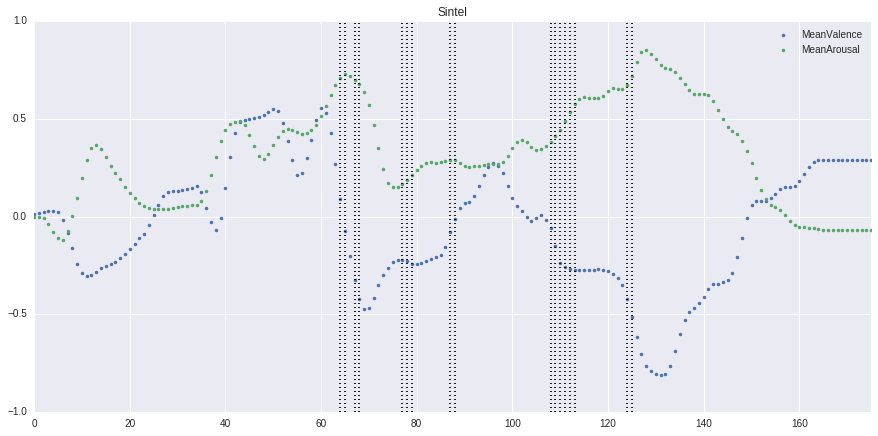

In [262]:
f = 'Sintel'
'''
        visualdf = getAvgVisFeatListDf(f,visual_feat_list)
        audiodf = getAudioDf(f)
        deepdf = getAvgVisFeatListDf(f,['fc6'])
        lowdf = getLowFeature10SecDf(f)
        facedf = getFaceFeature(f)
'''
        
df = getAnnotationDf(f)   
annotdf = getFearDf(f)
plt.figure(figsize=(15,7))

df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='.',title=f)
for i in range(annotdf.shape[0]):
    if (annotdf['Fear'][i]) >0:
        plt.axvline(x=i,linestyle=':',color='black')



In [263]:
#lowdf = getLowFeature10SecDf(f)
#lowdf.plot(style='-')

In [100]:
#lowdf[['lummean','motion']].plot()

In [101]:
#plot2graph(lowdf['lummean'],lowdf['motion'])

In [102]:
#plot2graph(df[['MeanValence','MeanArousal']],lowdf['lummean'])

In [103]:
#plot2graph(df['MeanValence'],lowdf['lummean'])

In [104]:
#plotFearDevSet(df, annotdf)

## Ploting Annotations (Fear, arousal,vallence ) 

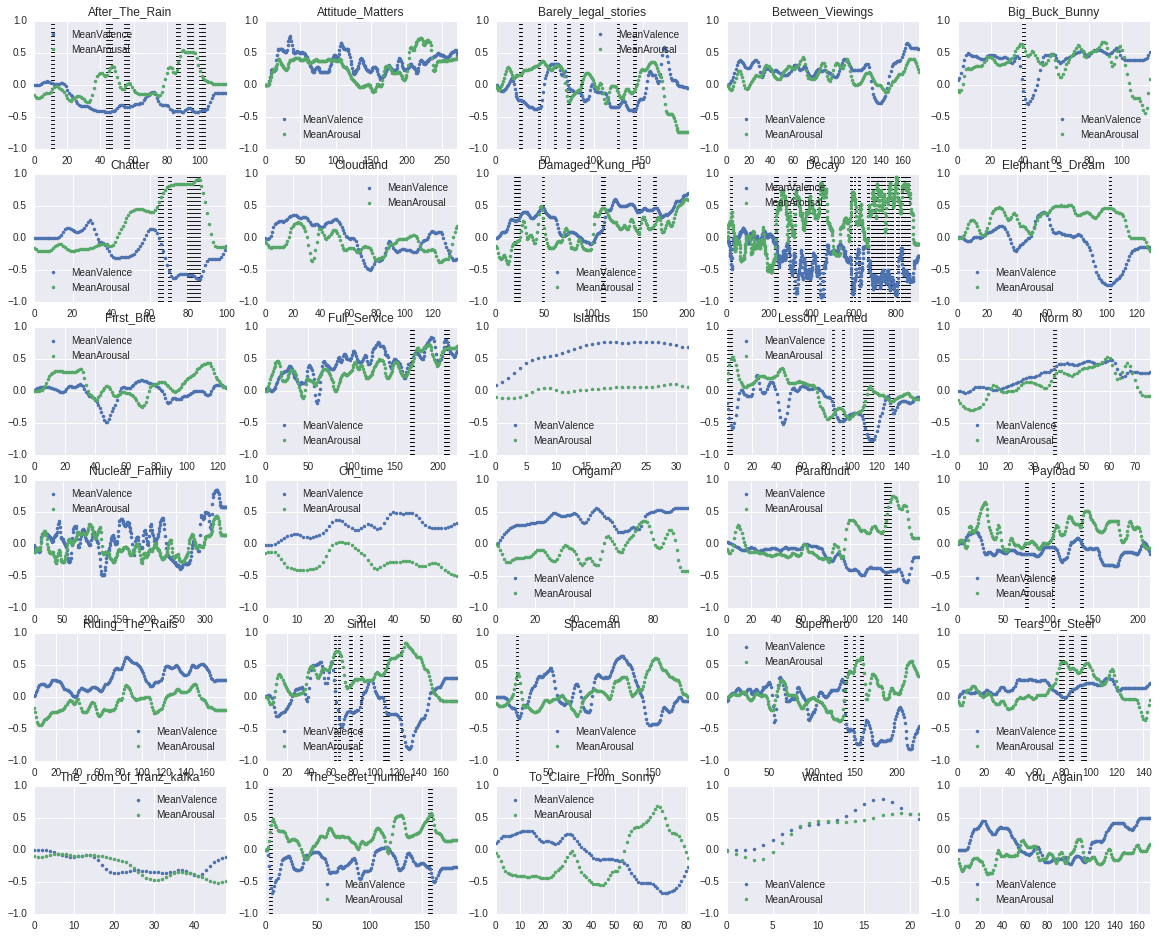

In [264]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    plt.axis([0, 2000, -1, 1 ])
    df = getAnnotationDf(mov)
    annotdf = getFearDf(mov)
    for i in range(annotdf.shape[0]):
        if (annotdf['Fear'][i]) >0:
            plt.axvline(x=i,linestyle = ':',color='black')
    df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='.',title=mov)


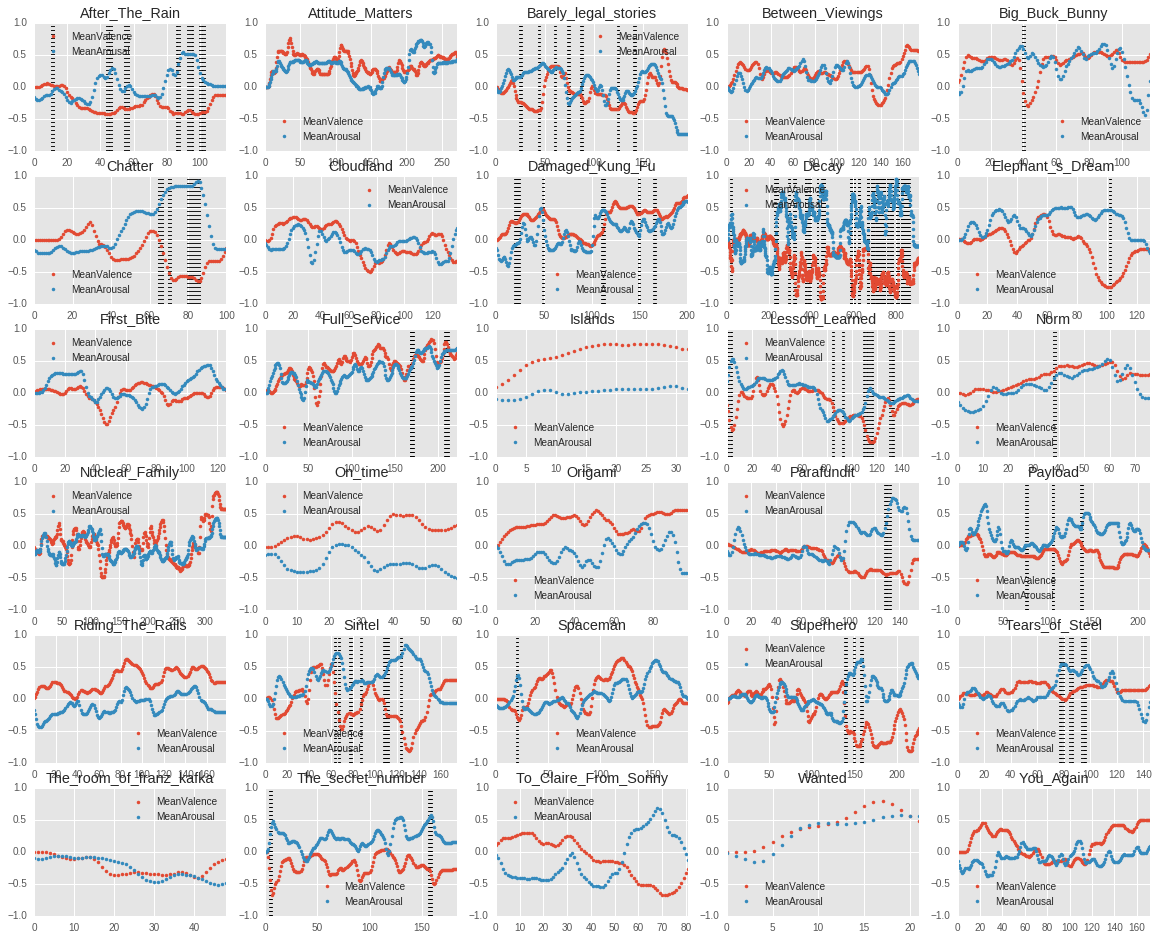

In [84]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    plt.axis([0, 2000, -1, 1 ])
    df = getAnnotationDf(mov)
    annotdf = getFearDf(mov)
    for i in range(annotdf.shape[0]):
        if (annotdf['Fear'][i]) >0:
            plt.axvline(x=i,linestyle = ':',color='black')
    df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='.',title=mov)


In [340]:
def getPrediction(f, feat = "visual"):
    
    visual_feat_list= ['acc', 'cedd', 'cl', 'eh', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]

    if feat=='visual':
        visualdf = getAvgVisFeatListDf(f,visual_feat_list)
        return pvisfear.predict(visualdf)
    elif feat=='audio':    
        audiodf = getAudioDf(f)
        return paudfear.predict(audiodf)
    elif feat=='deep': 
        deepdf = getAvgVisFeatListDf(f,['fc6'])
        return pdeepfear.predict(deepdf)
    elif feat=='low':     
        lowdf = getLowFeature10SecDf(f)
        return plowfear.predict(lowdf)
    elif feat=='face':    
        facedf = getFaceFeature(f)
        return pfacefear.predict(facedf)
    elif feat=='faceland':    
        facelanddf = getFaceLandmarkFeature(f)
        return pfacelandfear.predict(facelanddf)
    else:
        return []
    


In [302]:
visual_feat_list= ['acc', 'cedd', 'cl', 'eh', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]

def predictFearDevSet(f):
    if (f in movieNames):        
        visualdf = getAvgVisFeatListDf(f,visual_feat_list)
        audiodf = getAudioDf(f)
        deepdf = getAvgVisFeatListDf(f,['fc6'])
        lowdf = getLowFeature10SecDf(f)
        facedf = getFaceFeature(f)
        facelanddf = getFaceLandmarkFeature(f)
        
        annotdf = getFearDf(f)
        yf = df2mat(annotdf[['Fear']])
        
        print(audiodf.shape,visualdf.shape,deepdf.shape,lowdf.shape,facedf.shape,facelanddf.shape)

        mlen = min([len(audiodf),len(visualdf),len(deepdf),len(lowdf),len(facedf),len(facelanddf)])
 
        print "minimum {}".format(mlen)
        audiodf = audiodf[:mlen]
        visualdf = visualdf[:mlen]
        deepdf = deepdf[:mlen]
        lowdf = lowdf[:mlen]
        facedf = facedf[:mlen]
        facelanddf = facelanddf[:mlen]
        
        yf = yf[:mlen]

        visfear = pvisfear.predict(visualdf)        

        audfear = paudfear.predict(audiodf)     
                
        deepfear = pdeepfear.predict(deepdf)
        
        lowfear = plowfear.predict(lowdf)

        facefear = pfacefear.predict(facedf)
        
        faceland = pfacelandfear.predict(facelanddf)
        
        df = pd.DataFrame(np.transpose([visfear, audfear, deepfear, lowfear, facefear, faceland ]), 
                         columns=['visfear', 'audfear', 'deepfear', 'lowfear', 'facefear','facelandfear'])

    return df

In [344]:
predictFearDevSet('Chatter').describe()

((100, 1583), (101, 1271), (101, 4096), (101, 9), (101, 10), (101, 144))
minimum 100


visfear  audfear  deepfear     lowfear    facefear  facelandfear
count    100.0    100.0     100.0  100.000000  100.000000         100.0
mean       0.0      0.0       0.0    0.090000    0.110000           0.0
std        0.0      0.0       0.0    0.287623    0.314466           0.0
min        0.0      0.0       0.0    0.000000    0.000000           0.0
25%        0.0      0.0       0.0    0.000000    0.000000           0.0
50%        0.0      0.0       0.0    0.000000    0.000000           0.0
75%        0.0      0.0       0.0    0.000000    0.000000           0.0
max        0.0      0.0       0.0    1.000000    1.000000           0.0

((100, 1583), (101, 1271), (101, 4096), (101, 9), (101, 10), (101, 144))
minimum 100


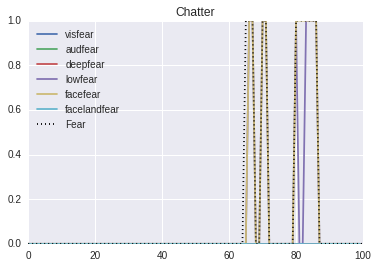

In [303]:
predictFearDevSet('Chatter').plot()
df = getFearDf('Chatter')
df[['Fear']].plot(ax=plt.gca(),linestyle=':',color='black',title='Chatter')


In [330]:
#getFaceLandmarkFeature('After_The_Rain')

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 144 columns]

In [332]:
predDict ={}
fearDict ={}
for ii, mov in enumerate(trainlist):
    df = getFearDf(mov)
    fearDict[mov] = df[['Fear']]
    predictions = predictFearDevSet(mov)
    predDict[mov] = predictions


((196, 1583), (197, 1271), (197, 4096), (205, 9), (196, 10), (196, 144))
minimum 196
((118, 1583), (118, 1271), (118, 4096), (118, 9), (118, 10), (118, 144))
minimum 118
((100, 1583), (101, 1271), (101, 4096), (101, 9), (101, 10), (101, 144))
minimum 100
((201, 1583), (202, 1271), (202, 4096), (202, 9), (202, 10), (202, 144))
minimum 201
((912, 1583), (912, 1271), (912, 4096), (951, 9), (912, 10), (912, 144))
minimum 912
((129, 1583), (130, 1271), (130, 4096), (129, 9), (129, 10), (129, 144))
minimum 129
((223, 1583), (223, 1271), (223, 4096), (230, 9), (223, 10), (223, 144))
minimum 223
((154, 1583), (155, 1271), (155, 4096), (160, 9), (154, 10), (154, 144))
minimum 154
((77, 1583), (77, 1271), (77, 4096), (77, 9), (77, 10), (77, 144))
minimum 77
((157, 1583), (157, 1271), (157, 4096), (157, 9), (157, 10), (157, 144))
minimum 157
((214, 1583), (214, 1271), (214, 4096), (214, 9), (214, 10), (214, 144))
minimum 214


((196, 1583), (197, 1271), (197, 4096), (205, 9), (196, 10), (196, 144))
minimum 196
((118, 1583), (118, 1271), (118, 4096), (118, 9), (118, 10), (118, 144))
minimum 118
((100, 1583), (101, 1271), (101, 4096), (101, 9), (101, 10), (101, 144))
minimum 100
((201, 1583), (202, 1271), (202, 4096), (202, 9), (202, 10), (202, 144))
minimum 201
((912, 1583), (912, 1271), (912, 4096), (951, 9), (912, 10), (912, 144))
minimum 912
((129, 1583), (130, 1271), (130, 4096), (129, 9), (129, 10), (129, 144))
minimum 129
((223, 1583), (223, 1271), (223, 4096), (230, 9), (223, 10), (223, 144))
minimum 223
((154, 1583), (155, 1271), (155, 4096), (160, 9), (154, 10), (154, 144))
minimum 154
((77, 1583), (77, 1271), (77, 4096), (77, 9), (77, 10), (77, 144))
minimum 77
((157, 1583), (157, 1271), (157, 4096), (157, 9), (157, 10), (157, 144))
minimum 157
((214, 1583), (214, 1271), (214, 4096), (214, 9), (214, 10), (214, 144))
minimum 214


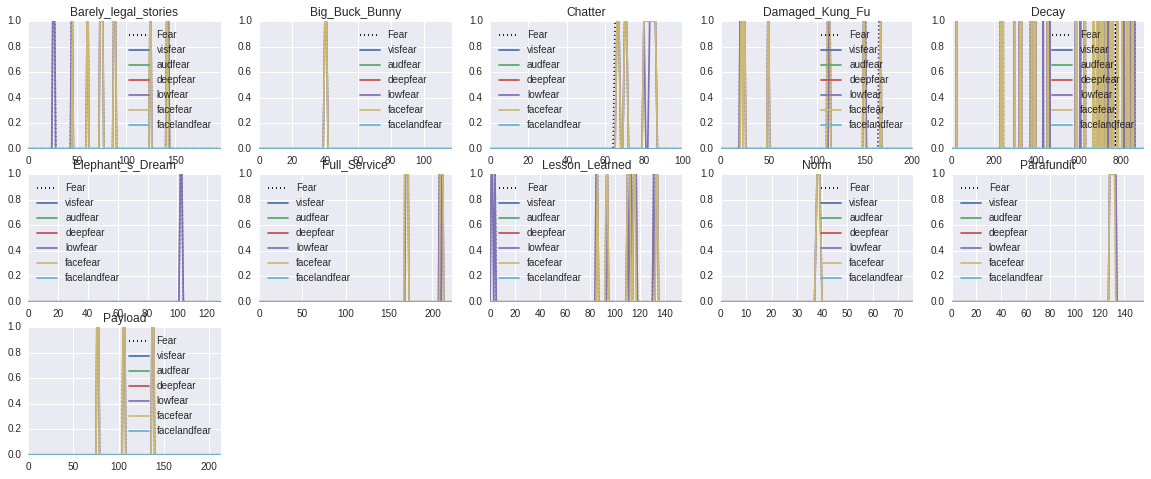

In [331]:
### Runs slow, does not use the computed dictionaries 
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(trainlist):
    plt.subplot(4,4,ii+1)
    df = getFearDf(mov)
    df[['Fear']].plot(ax=plt.gca(),color='black',linestyle=':',title=mov)
    
    predictions = predictFearDevSet(mov)
    predictions.plot(ax=plt.gca(),title=mov)
    
   
    #for i in range(len(cuts)):
    #    x=cuts[i]/5   ## conversion of time to sliding windows with 5 
    #    plt.axvline(x,linestyle='-',color='black')


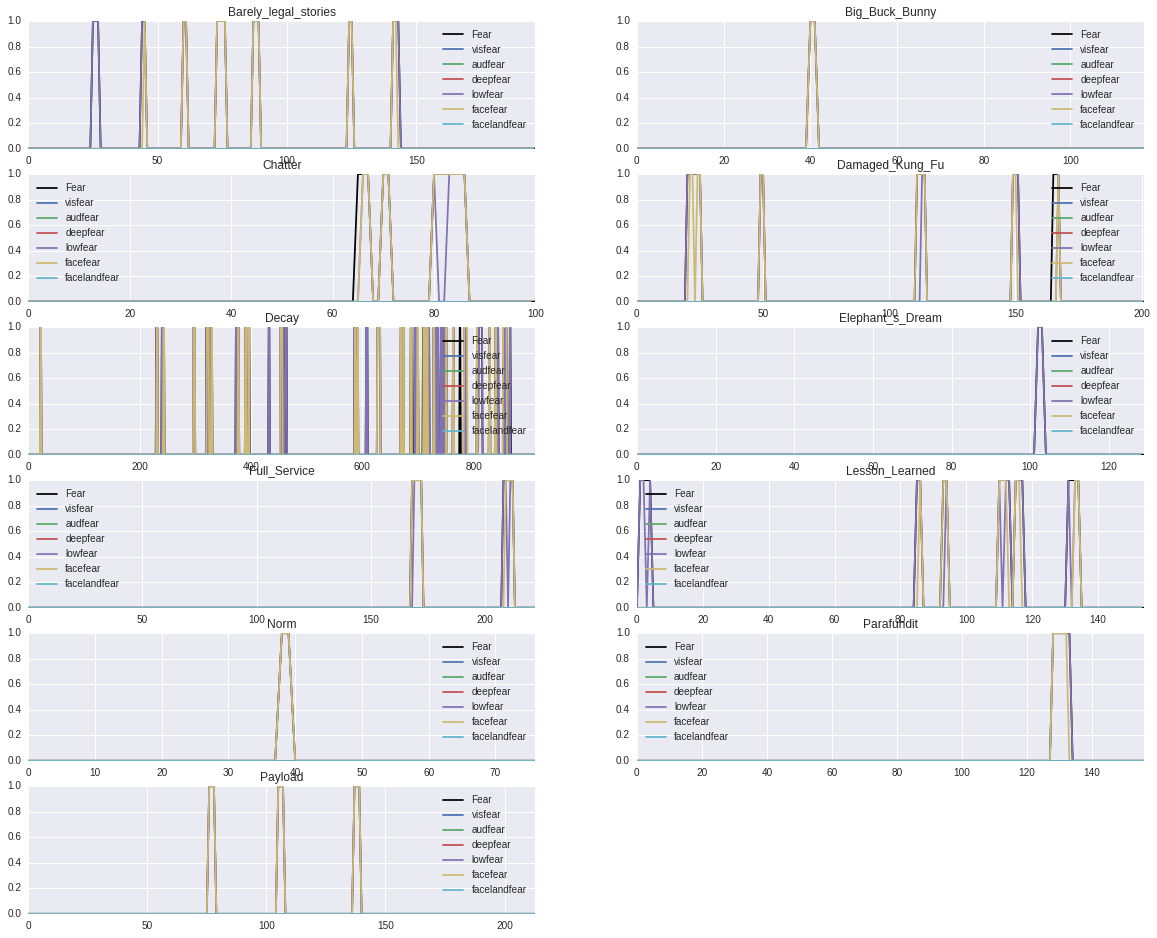

In [338]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(trainlist):
    plt.subplot(6,2,ii+1)
    fearDict[mov].plot(ax=plt.gca(),color='black',title=mov)
    predDict[mov].plot(ax=plt.gca(),title=mov)


In [341]:
predDict['Chatter'].head()

visfear  audfear  deepfear  lowfear  facefear  facelandfear
0        0        0         0        0         0             0
1        0        0         0        0         0             0
2        0        0         0        0         0             0
3        0        0         0        0         0             0
4        0        0         0        0         0             0

In [105]:
def predictFearTestSet(f):
    audiodf = getAudioDf(f,folder=med2017audiofolderTest)
    visualdf = getAvgVisFeatListDf(f,visual_feat_list,
                                   folder=med2017visualfolderTest)
    deepdf = getAvgVisFeatListDf(f,['fc6'],
                                    folder=med2017visualfolderTest)
    ## dev set and test set feature are at the same folder
    lowdf = getLowFeature10SecDf(f) 
    facedf = getFaceFeature(f)       
    print(audiodf.shape,visualdf.shape,deepdf.shape,lowdf.shape,facedf.shape)
    mlen = min([len(audiodf),len(visualdf),len(deepdf),len(lowdf),len(facedf)])

    audiodf = audiodf[:mlen]
    visualdf = visualdf[:mlen]
    deepdf = deepdf[:mlen]
    lowdf = lowdf[:mlen]
    facedf= facedf[:mlen]
        
    
    visfear = pvisfear.predict(visualdf)        
    audfear = paudfear.predict(audiodf)                     
    deepfear = pdeepfear.predict(deepdf)        
    lowfear = plowfear.predict(lowdf)
    facefear = pfacefear.predict(facedf)
        
    df =pd.DataFrame(np.transpose([visfear, audfear, deepfear, lowfear, facefear ]),
                     columns=['visfear', 'audfear', 'deepfear', 'lowfear', 'facefear'])

    return df

In [108]:
#pred = predictFearTestSet('MEDIAEVAL17_05')

In [109]:
#pred.plot()

In [110]:
def writeToFile(f,fearpred):
    df = pd.DataFrame(np.transpose([fearpred]), 
                      columns=['Fear'])
    sfilename= f+".csv"
    df.to_csv(sfilename, index=False)

def appendToFile(movie,fname,fearpred):
    fd = open(fname, 'a')
    fd.write(movie+'\n')  # python will convert \n to os.linesep
    fd.close()
    df = pd.DataFrame(np.transpose([fearpred]), columns=['Fear'])
    df.to_csv(fname, sep=' ', index=False, header=False, mode='a')

In [111]:
audiopipefile = './me17ei_audio_fear.txt'
visualpipefile = './me17ei_visual_fear.txt'
deeppipefile = './me17ei_deep_fear.txt'
lowlevelpipefile = './me17ei_lowlevel_fear.txt'
facepipefile = './me17ei_face_fear.txt'


for f in testmovieNames:
    pred = predictFearTestSet(f)
    appendToFile(f,audiopipefile,pred['audfear'])
    appendToFile(f,visualpipefile,pred['visfear'])
    appendToFile(f,deeppipefile,pred['deepfear'])
    appendToFile(f,lowlevelpipefile,pred['lowfear'])
    

NameError: global name 'visual_feat_list' is not defined

In [106]:
for f in testmovieNames:
    appendToFile(f,facepipefile,pred['facefear'])

## svc 

In [ ]:
%%time
lgcv = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False)
lgcv.fit(Xtrainv, ytrain)

lgca = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False)
lgca.fit(Xtraina, ytrain)

print('Visual SVC :\n {}\n'.format(metrics.classification_report(ytest,lgcv.predict(Xtestv))))
print('Visual SVC AVP: {:.2f}'.format(metrics.average_precision_score(ytest,lgcv.predict(Xtestv) , average='macro')))
print('Visual SVC Accuracy:       {:.2f}'.format(metrics.accuracy_score(ytest,lgcv.predict(Xtestv))))

print('Audio SVC:\n {}\n'.format(metrics.classification_report(ytest,lgca.predict(Xtesta)))) 
print('Audio SVC AVP: {:.2f}'.format(metrics.average_precision_score(ytest,lgca.predict(Xtesta) , average='macro')))
print('Audio SVC Accuracy:       {:.2f}'.format(metrics.accuracy_score(ytest,lgca.predict(Xtesta))))

latefusionXtrain = np.transpose([lgcv.predict(Xtrainv),lgca.predict(Xtraina)])

fuslgc = LogisticRegression(C=0.01)
fuslgc.fit(latefusionXtrain,ytrain)

#Test
latefusionXtest = np.transpose([lgcv.predict(Xtestv),lgca.predict(Xtesta)])
pred_ytest = fuslgc.predict(latefusionXtest)

print('Fusion Logistic Regression:\n {}\n'.format(metrics.classification_report(pred_ytest,ytest)))



## grid search

In [ ]:
pipegrad = GradientBoostingClassifier(learning_rate=0.05, 
                           n_estimators=60,max_depth=9,
                           max_features='sqrt', subsample=0.8, 
                           random_state=10) 

In [65]:
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', SVC())])

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 1, 10],
     'classifier__C': [0.01, 1, 10,100]}]


grid = GridSearchCV(pipe, param_grid, cv=5,n_jobs=4)
grid.fit(tXv,ty)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
#grid.grid_scores_, grid.best_params_, grid.best_score_

Best params:
{'classifier__gamma': 0.001, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'classifier': SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 0.01}

Best cross-validation score: 0.94


In [ ]:
pipe = Pipeline([('preprocessing', StandardScaler()))])

param_grid2 = [{'classifier': [RandomForestClassifier],
     'preprocessing': [None],
     'classifier__n_estimators': [50,100,300],
     'classifier__max_features': [3,5,10]},
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 1, 10],
     'classifier__C': [0.01, 1, 10,100]}]

grid = GridSearchCV(pipe, param_grid, cv=5,n_jobs=4)
grid.fit(tXl,ty)

estimator = RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, 
                                   min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_features=’auto’, 
                                   max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, bootstrap=True, oob_score=False, 
                                   n_jobs=1, random_state=None, verbose=0, warm_start=False, 
                                   class_weight=None)

In [147]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}

pipegrad = GradientBoostingClassifier(learning_rate=0.05, 
                           n_estimators=60,max_depth=9,
                           max_features='sqrt', subsample=0.8, 
                           random_state=10) 

gsearch3 = GridSearchCV(pipegrad , param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch3.fit(Xtraina,ytrain)
#gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score

In [155]:
X_train, X_test, y_train, y_test = train_test_split(tXv, ty,test_size=0.2, random_state=0)

In [156]:
Xa_train, Xa_test, ya_train, ya_test = train_test_split(tXa, ty,test_size=0.2, random_state=0)

In [157]:
Xd_train, Xd_test, yd_train, yd_test = train_test_split(tXd, ty,test_size=0.2, random_state=0)

In [158]:
Xl_train, Xl_test, yl_train, yl_test = train_test_split(tXl, ty,test_size=0.2, random_state=0)
Xl_train.shape, Xl_test.shape, yl_train.shape, yl_test.shape

((3620, 9), (906, 9), (3620, 1), (906, 1))

((22, 1583), (22, 1271), (22, 4096), (22, 9))
(22, 4)


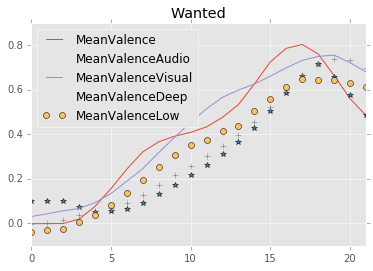

In [131]:
mov = 'Wanted'
df = predictEmo(mov)
dfa = getAnnotationDf(mov)
print dfa.shape

dfa[['MeanValence']].plot(ax=plt.gca(),title=mov)

df[['MeanValenceAudio']].plot(ax=plt.gca(), style=['*'], title=mov)
df[['MeanValenceVisual']].plot(ax=plt.gca(), style=['-'], title=mov)
df[['MeanValenceDeep']].plot(ax=plt.gca(), style=['+'], title=mov)
df[['MeanValenceLow']].plot(ax=plt.gca(), style=['o'], title=mov)


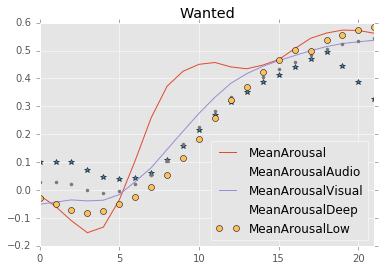

In [136]:
dfa[['MeanArousal']].plot(ax=plt.gca(),title=mov)

df[['MeanArousalAudio']].plot(ax=plt.gca(), style=['*'], title=mov)
df[['MeanArousalVisual']].plot(ax=plt.gca(), style=['-'], title=mov)
df[['MeanArousalDeep']].plot(ax=plt.gca(), style=['.'], title=mov)
df[['MeanArousalLow']].plot(ax=plt.gca(), style=['o'], title=mov)
